In [1]:
%matplotlib inline

import numpy as np
import copy


import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim, cfg_default_lr, cfg_default_early, cfg_policy_evaluation_maxiter
seed = cfg_seed
env_str=cfg_env
default_lr=cfg_default_lr
default_early=cfg_default_early

from config import cfg_alpha
alpha=cfg_alpha

num_iter_max=200000
env_name = 'CustomCartPole-v0'
env_str=cfg_env
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter1_"

loss_list = []
normalized_loss_list = []

policy_evaluation_maxiter = cfg_policy_evaluation_maxiter
print("policy_evaluation_maxiter",policy_evaluation_maxiter)
print("alpha",alpha)
print("seed",seed)
print(datetime.datetime.now())

policy_evaluation_maxiter 5
alpha 0.2
seed 4
2023-08-19 08:06:53.152287


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)



4 1 2


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_standardvae_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_cartpole_bamdp_standardvae_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

iwvi.load_base(ckpt_key="unweighted")
# iwvi.update_mulogvar_offlinedata()

dec: h_dim 64
base load ckpt ckpt_basevi_cartpole_unweighted
base load self.initial_belief.data.sum() tensor(-11.0065)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(-2.3922)
penalty_target_min tensor(-11.0972) penalty_target_max tensor(10.5368)
train_loss:  -7.944463903427125
valid_loss:  -7.560206010437012
h_min_tilde -11.097233 ell_tilde -7.8676123248291026 kappa_tilde 0.00027822378735638064


In [5]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 9.5367431640625e-07


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):



 1 6.9769909381866455

 2 7.02431058883667

 3 6.778607606887817

 4 7.163227081298828

 5 6.184787750244141

 6 3.3814592361450195

 7 3.4689061641693115

 8 3.4590461254119873

 9 3.3818633556365967

 10 3.362215518951416

 11 3.457684278488159

 12 3.3244922161102295

 13 3.344043493270874

 14 2.9901764392852783

 15 4.330432176589966

 16 3.5280508995056152

 17 3.374946117401123

 18 3.4780774116516113

 19 3.1729044914245605

 20 5.608116865158081

 21 6.969744682312012

 22 6.8241517543792725

 23 6.619738340377808

 24 5.9728052616119385

 25 6.698107004165649

 26 6.608945369720459

 27 6.943858623504639

 28 6.685478448867798

 29 6.851794242858887

 30 7.067782640457153

 31 7.0570313930511475

 32 5.416474342346191

 33 4.244070053100586

 34 3.6355655193328857

 35 3.544816732406616

 36 3.5072455406188965

 37 6.274639368057251

 38 6.676993131637573

 39 3.604867935180664

 40 3.4377946853637695

 41 3.541137933731079

 42 3.588993549346924

 43 3.530836820602417

 44 

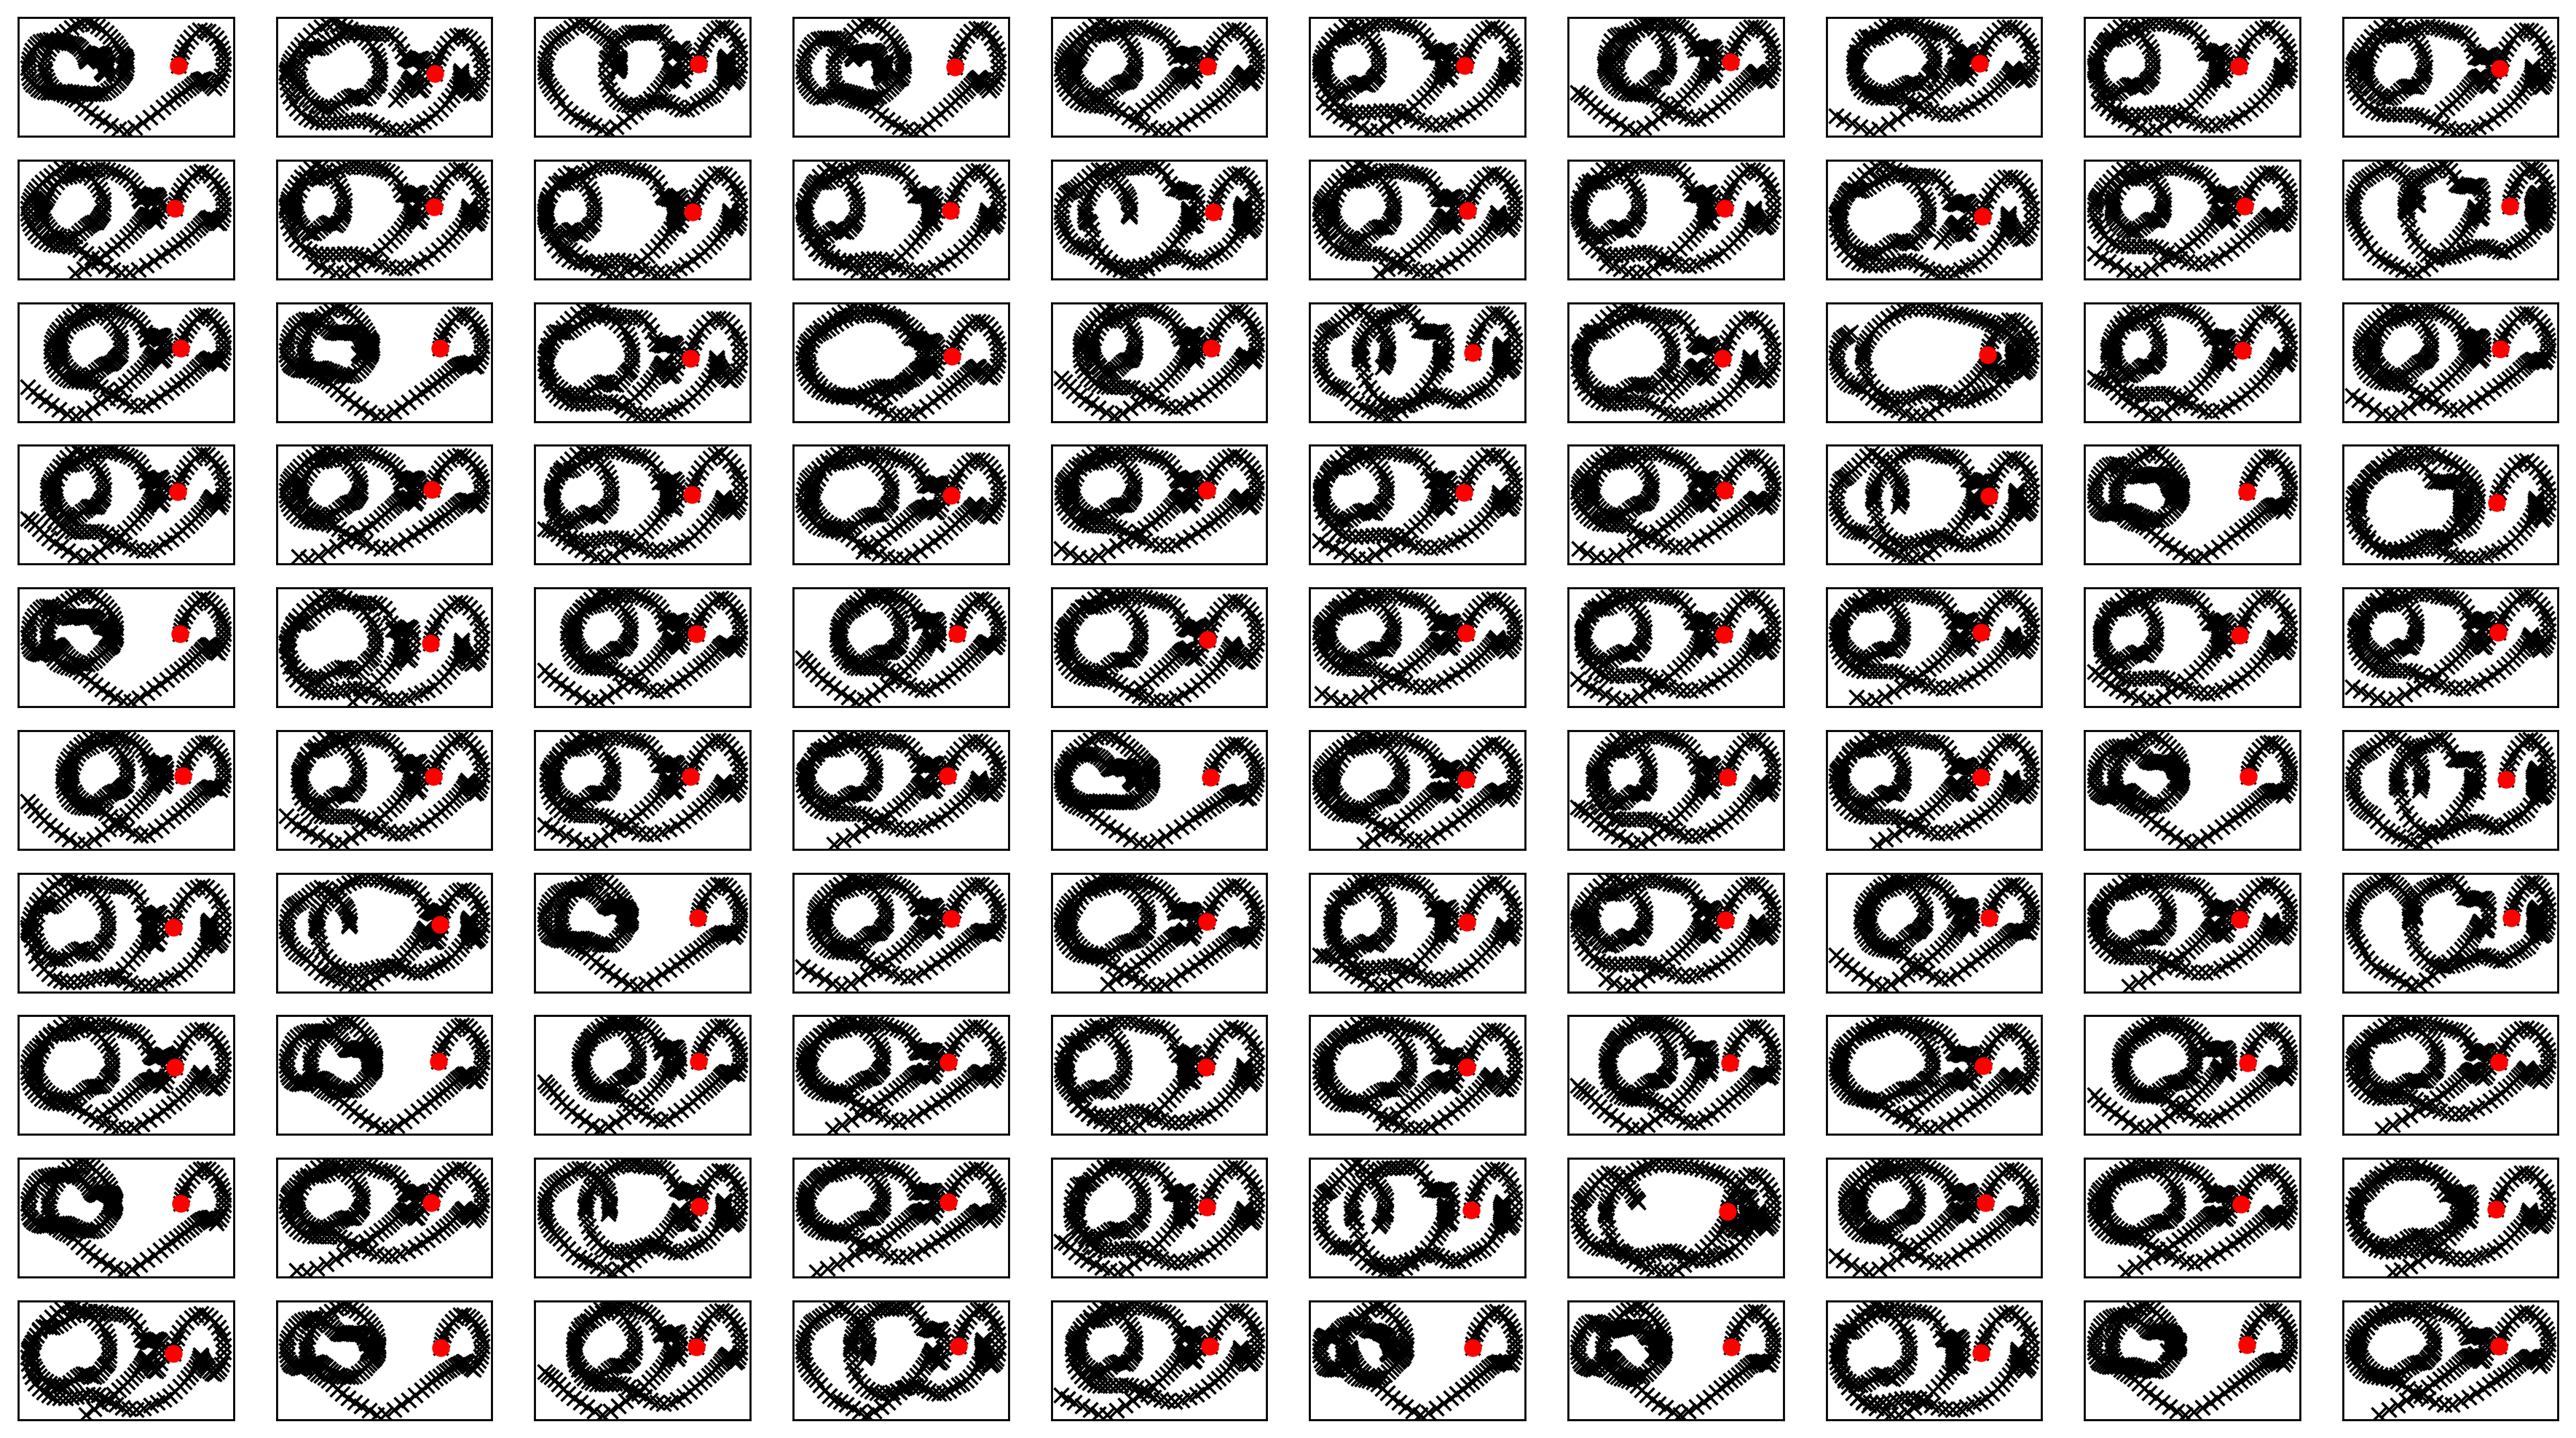

In [6]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

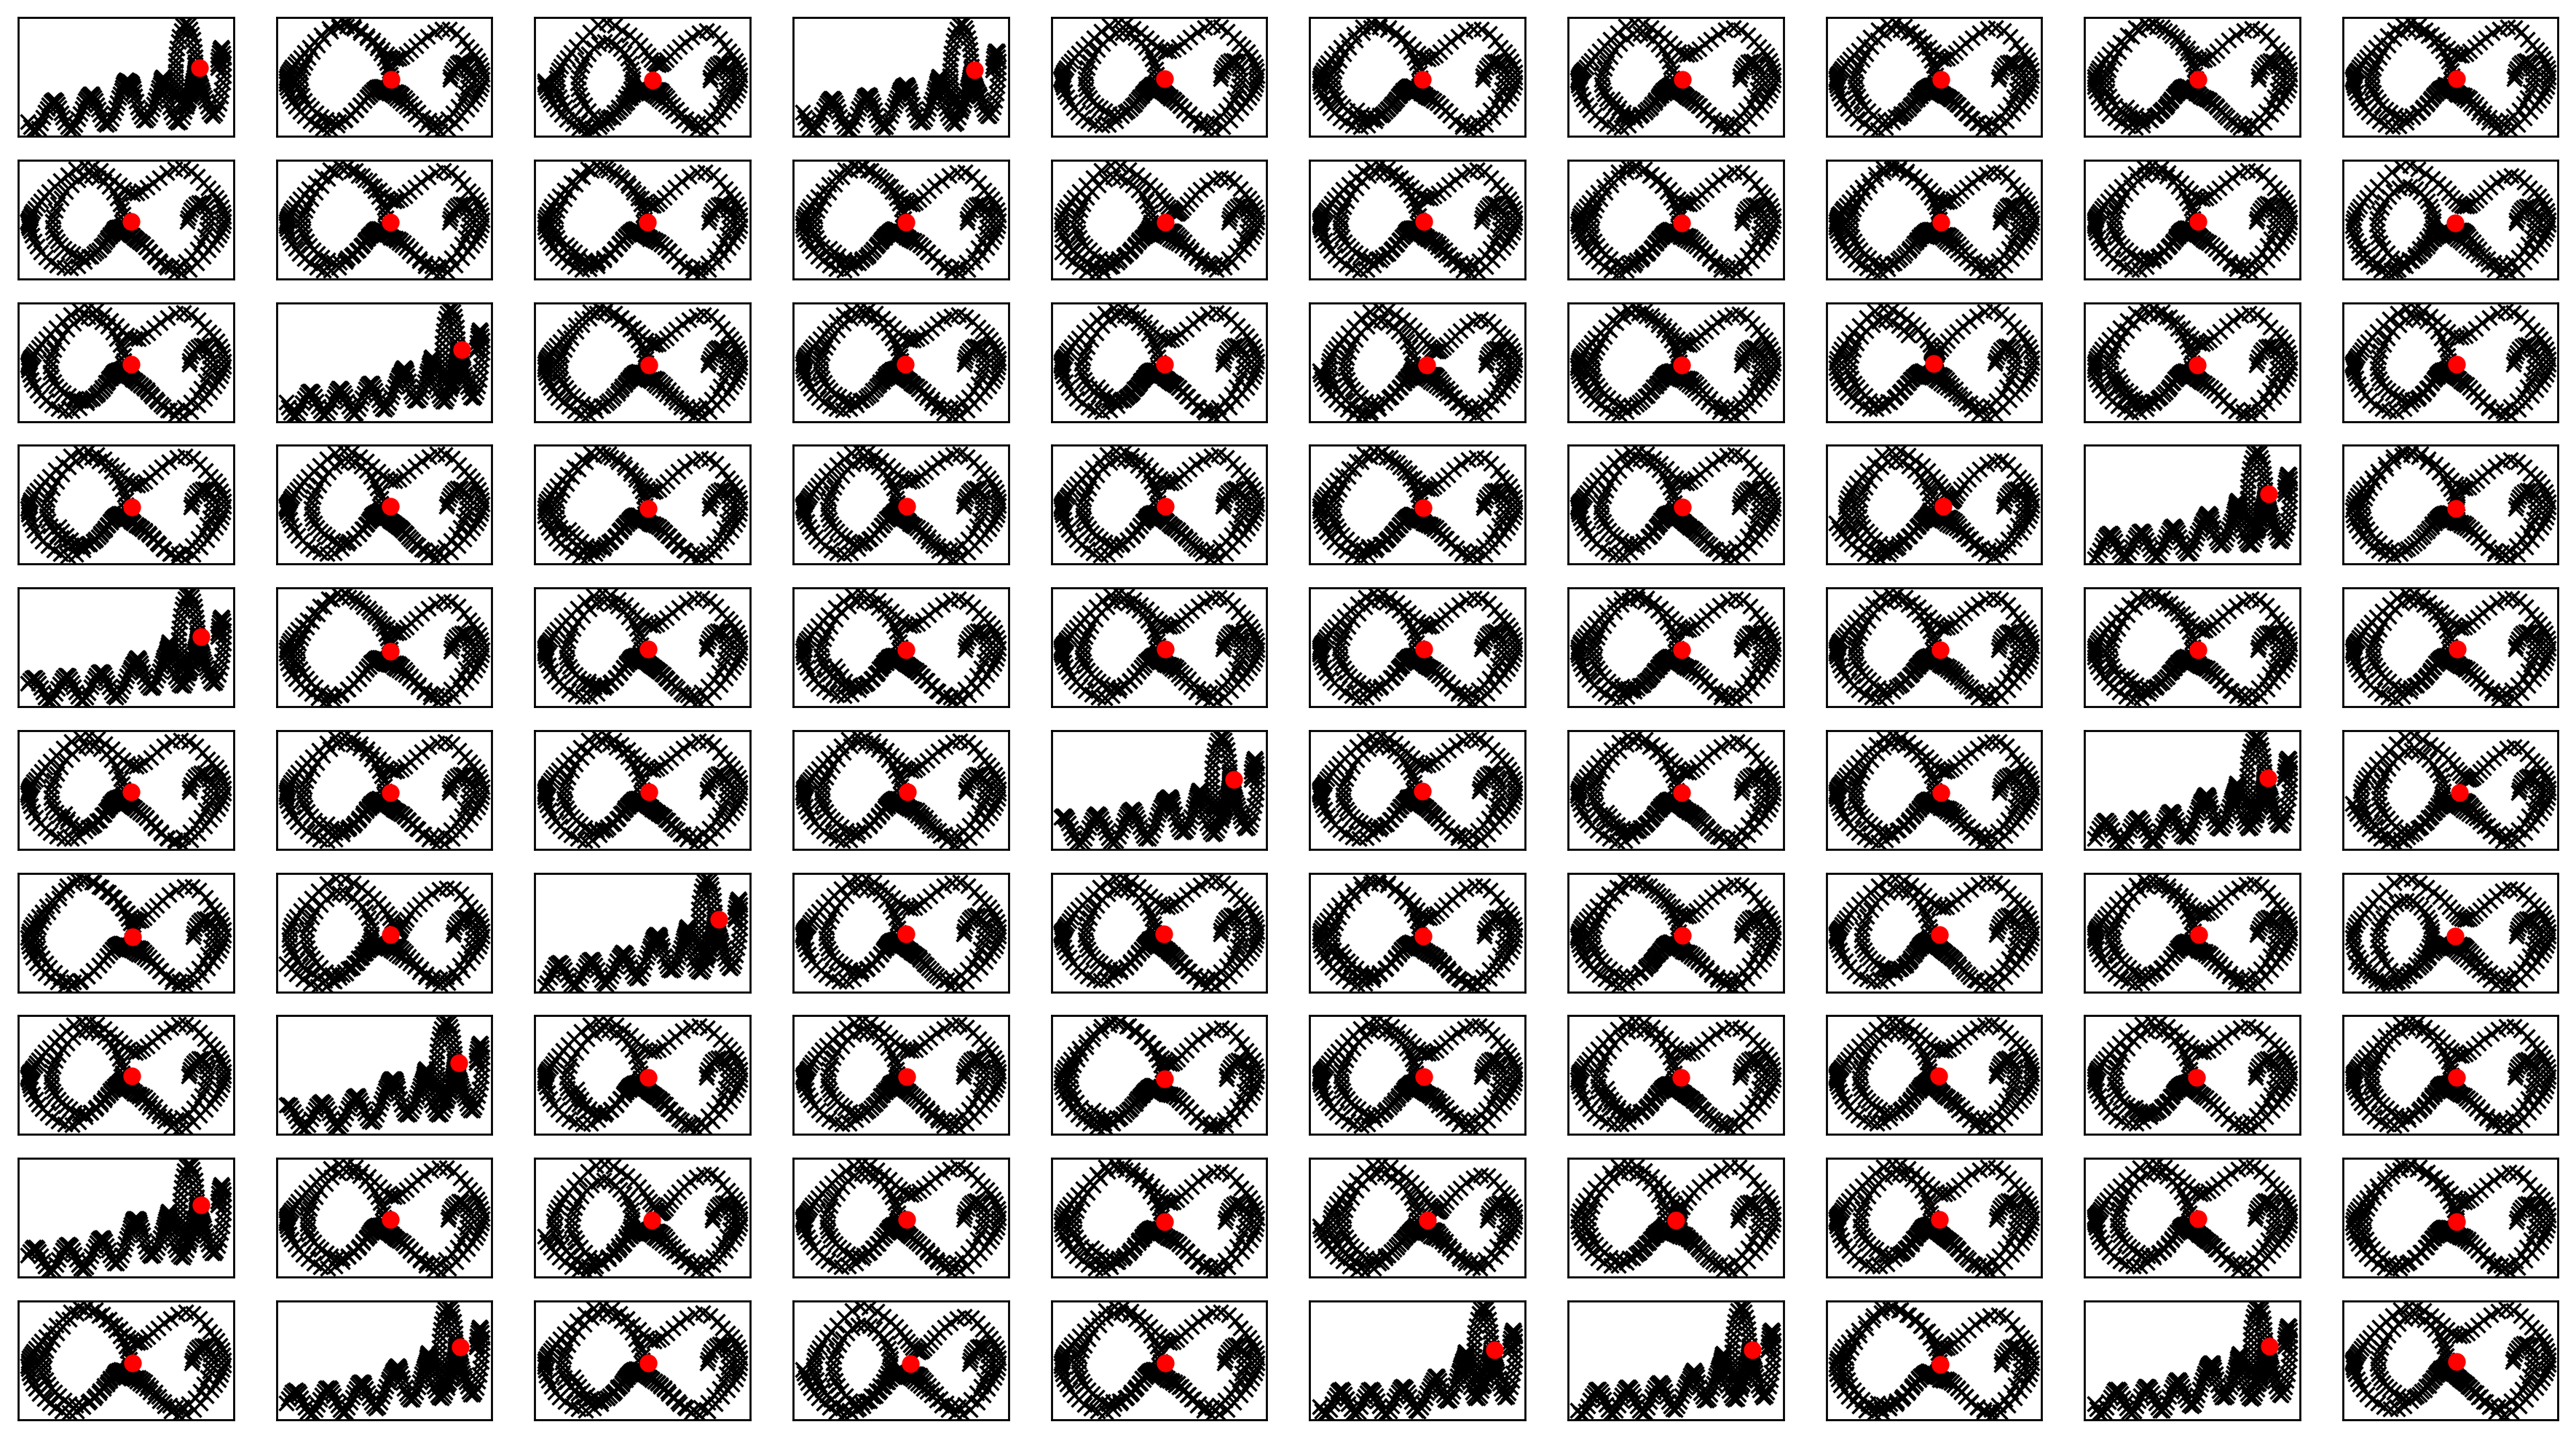

<Figure size 640x480 with 0 Axes>

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,2], iwvi.debug_realenv_rolloutdata[i][:,3],"kx")
    ax_list[-1].plot(0, 0,"ro") 
# plt.show()
plt.savefig(figfilenamehead+"iter0.png")
# plt.savefig(figfilenamehead+"iter0.pdf")
plt.savefig(figfilenamehead+"iter0.eps")

In [8]:
print(datetime.datetime.now())

2023-08-19 08:14:24.478111


# Iter 1

In [9]:
policy_evaluation_iter=0

In [10]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [11]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.32949  validloss 1.42456±0.00000  bestvalidloss 1.42456  last_update 0
train: iter 1  trainloss 1.21153  validloss 1.23014±0.00000  bestvalidloss 1.23014  last_update 0
train: iter 2  trainloss 1.10399  validloss 1.11256±0.00000  bestvalidloss 1.11256  last_update 0
train: iter 3  trainloss 0.96807  validloss 1.02960±0.00000  bestvalidloss 1.02960  last_update 0
train: iter 4  trainloss 0.84817  validloss 0.89621±0.00000  bestvalidloss 0.89621  last_update 0
train: iter 5  trainloss 0.76717  validloss 0.78175±0.00000  bestvalidloss 0.78175  last_update 0
train: iter 6  trainloss 0.72990  validloss 0.72979±0.00000  bestvalidloss 0.72979  last_update 0
train: iter 7  trainloss 0.69657  validloss 0.68690±0.00000  bestvalidloss 0.68690  last_update 0
train: iter 8  trainloss 0.66466  validloss 0.65567±0.00000  bestvalidloss 0.65567  last_update 0
train: iter 9  trainloss 0.64563  validloss 0.63004±0.00000  bestvalidloss 0.63004  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.39700  validloss 0.42865±0.00000  bestvalidloss 0.40535  last_update 1
train: iter 84  trainloss 0.39994  validloss 0.40600±0.00000  bestvalidloss 0.40535  last_update 2
train: iter 85  trainloss 0.39581  validloss 0.40743±0.00000  bestvalidloss 0.40535  last_update 3
train: iter 86  trainloss 0.39940  validloss 0.41541±0.00000  bestvalidloss 0.40535  last_update 4
train: iter 87  trainloss 0.39149  validloss 0.40620±0.00000  bestvalidloss 0.40535  last_update 5
train: iter 88  trainloss 0.40151  validloss 0.40500±0.00000  bestvalidloss 0.40500  last_update 0
train: iter 89  trainloss 0.39678  validloss 0.42983±0.00000  bestvalidloss 0.40500  last_update 1
train: iter 90  trainloss 0.39928  validloss 0.40683±0.00000  bestvalidloss 0.40500  last_update 2
train: iter 91  trainloss 0.39447  validloss 0.40102±0.00000  bestvalidloss 0.40102  last_update 0
train: iter 92  trainloss 0.39163  validloss 0.40180±0.00000  bestvalidloss 0.40102  last_update 1
train: ite

train: iter 166  trainloss 0.35281  validloss 0.38379±0.00000  bestvalidloss 0.37794  last_update 9
train: iter 167  trainloss 0.35349  validloss 0.37889±0.00000  bestvalidloss 0.37794  last_update 10
train: iter 168  trainloss 0.35664  validloss 0.40685±0.00000  bestvalidloss 0.37794  last_update 11
train: iter 169  trainloss 0.34861  validloss 0.38159±0.00000  bestvalidloss 0.37794  last_update 12
train: iter 170  trainloss 0.35056  validloss 0.38495±0.00000  bestvalidloss 0.37794  last_update 13
train: iter 171  trainloss 0.34970  validloss 0.38739±0.00000  bestvalidloss 0.37794  last_update 14
train: iter 172  trainloss 0.34580  validloss 0.38252±0.00000  bestvalidloss 0.37794  last_update 15
train: iter 173  trainloss 0.35217  validloss 0.39713±0.00000  bestvalidloss 0.37794  last_update 16
train: iter 174  trainloss 0.34755  validloss 0.38188±0.00000  bestvalidloss 0.37794  last_update 17
train: iter 175  trainloss 0.35199  validloss 0.38039±0.00000  bestvalidloss 0.37794  last_u

train: iter 248  trainloss 0.32931  validloss 0.37549±0.00000  bestvalidloss 0.36920  last_update 2
train: iter 249  trainloss 0.32435  validloss 0.37762±0.00000  bestvalidloss 0.36920  last_update 3
train: iter 250  trainloss 0.32330  validloss 0.36734±0.00000  bestvalidloss 0.36734  last_update 0
train: iter 251  trainloss 0.32225  validloss 0.36986±0.00000  bestvalidloss 0.36734  last_update 1
train: iter 252  trainloss 0.33932  validloss 0.39690±0.00000  bestvalidloss 0.36734  last_update 2
train: iter 253  trainloss 0.32682  validloss 0.36652±0.00000  bestvalidloss 0.36652  last_update 0
train: iter 254  trainloss 0.32465  validloss 0.36482±0.00000  bestvalidloss 0.36482  last_update 0
train: iter 255  trainloss 0.31942  validloss 0.36271±0.00000  bestvalidloss 0.36271  last_update 0
train: iter 256  trainloss 0.32217  validloss 0.36953±0.00000  bestvalidloss 0.36271  last_update 1
train: iter 257  trainloss 0.31951  validloss 0.36230±0.00000  bestvalidloss 0.36230  last_update 0


train: iter 330  trainloss 0.31898  validloss 0.35815±0.00000  bestvalidloss 0.34628  last_update 6
train: iter 331  trainloss 0.30336  validloss 0.34715±0.00000  bestvalidloss 0.34628  last_update 7
train: iter 332  trainloss 0.30511  validloss 0.34451±0.00000  bestvalidloss 0.34451  last_update 0
train: iter 333  trainloss 0.30727  validloss 0.35198±0.00000  bestvalidloss 0.34451  last_update 1
train: iter 334  trainloss 0.30333  validloss 0.34638±0.00000  bestvalidloss 0.34451  last_update 2
train: iter 335  trainloss 0.30339  validloss 0.35203±0.00000  bestvalidloss 0.34451  last_update 3
train: iter 336  trainloss 0.29983  validloss 0.34579±0.00000  bestvalidloss 0.34451  last_update 4
train: iter 337  trainloss 0.30331  validloss 0.35041±0.00000  bestvalidloss 0.34451  last_update 5
train: iter 338  trainloss 0.31278  validloss 0.35108±0.00000  bestvalidloss 0.34451  last_update 6
train: iter 339  trainloss 0.30797  validloss 0.35147±0.00000  bestvalidloss 0.34451  last_update 7


train: iter 412  trainloss 0.29588  validloss 0.35203±0.00000  bestvalidloss 0.34168  last_update 19
train: iter 413  trainloss 0.29100  validloss 0.34462±0.00000  bestvalidloss 0.34168  last_update 20
train: iter 414  trainloss 0.29783  validloss 0.34534±0.00000  bestvalidloss 0.34168  last_update 21
train: iter 415  trainloss 0.29109  validloss 0.34465±0.00000  bestvalidloss 0.34168  last_update 22
train: iter 416  trainloss 0.29100  validloss 0.34392±0.00000  bestvalidloss 0.34168  last_update 23
train: iter 417  trainloss 0.29028  validloss 0.34747±0.00000  bestvalidloss 0.34168  last_update 24
train: iter 418  trainloss 0.29524  validloss 0.34708±0.00000  bestvalidloss 0.34168  last_update 25
train: iter 419  trainloss 0.28925  validloss 0.34135±0.00000  bestvalidloss 0.34135  last_update 0
train: iter 420  trainloss 0.29423  validloss 0.34187±0.00000  bestvalidloss 0.34135  last_update 1
train: iter 421  trainloss 0.29759  validloss 0.35276±0.00000  bestvalidloss 0.34135  last_up

train: iter 494  trainloss 0.28275  validloss 0.33975±0.00000  bestvalidloss 0.33975  last_update 0
train: iter 495  trainloss 0.28127  validloss 0.33844±0.00000  bestvalidloss 0.33844  last_update 0
train: iter 496  trainloss 0.28802  validloss 0.34382±0.00000  bestvalidloss 0.33844  last_update 1
train: iter 497  trainloss 0.28350  validloss 0.34003±0.00000  bestvalidloss 0.33844  last_update 2
train: iter 498  trainloss 0.28136  validloss 0.34219±0.00000  bestvalidloss 0.33844  last_update 3
train: iter 499  trainloss 0.28464  validloss 0.34013±0.00000  bestvalidloss 0.33844  last_update 4
train: iter 500  trainloss 0.29138  validloss 0.36421±0.00000  bestvalidloss 0.33844  last_update 5
train: iter 501  trainloss 0.28458  validloss 0.34219±0.00000  bestvalidloss 0.33844  last_update 6
train: iter 502  trainloss 0.28316  validloss 0.34338±0.00000  bestvalidloss 0.33844  last_update 7
train: iter 503  trainloss 0.28132  validloss 0.34852±0.00000  bestvalidloss 0.33844  last_update 8


train: iter 576  trainloss 0.27437  validloss 0.33923±0.00000  bestvalidloss 0.33805  last_update 46
train: iter 577  trainloss 0.27685  validloss 0.34026±0.00000  bestvalidloss 0.33805  last_update 47
train: iter 578  trainloss 0.27539  validloss 0.34852±0.00000  bestvalidloss 0.33805  last_update 48
train: iter 579  trainloss 0.28054  validloss 0.34910±0.00000  bestvalidloss 0.33805  last_update 49
train: iter 580  trainloss 0.27657  validloss 0.35736±0.00000  bestvalidloss 0.33805  last_update 50
train: iter 581  trainloss 0.27727  validloss 0.34092±0.00000  bestvalidloss 0.33805  last_update 51
train: iter 582  trainloss 0.27569  validloss 0.33960±0.00000  bestvalidloss 0.33805  last_update 52
train: iter 583  trainloss 0.27499  validloss 0.34344±0.00000  bestvalidloss 0.33805  last_update 53
train: iter 584  trainloss 0.27532  validloss 0.34822±0.00000  bestvalidloss 0.33805  last_update 54
train: iter 585  trainloss 0.27069  validloss 0.34030±0.00000  bestvalidloss 0.33805  last_

train: iter 658  trainloss 0.26983  validloss 0.34128±0.00000  bestvalidloss 0.33495  last_update 33
train: iter 659  trainloss 0.27276  validloss 0.34245±0.00000  bestvalidloss 0.33495  last_update 34
train: iter 660  trainloss 0.26833  validloss 0.33584±0.00000  bestvalidloss 0.33495  last_update 35
train: iter 661  trainloss 0.26818  validloss 0.34000±0.00000  bestvalidloss 0.33495  last_update 36
train: iter 662  trainloss 0.26774  validloss 0.33883±0.00000  bestvalidloss 0.33495  last_update 37
train: iter 663  trainloss 0.26609  validloss 0.34737±0.00000  bestvalidloss 0.33495  last_update 38
train: iter 664  trainloss 0.26961  validloss 0.34020±0.00000  bestvalidloss 0.33495  last_update 39
train: iter 665  trainloss 0.26629  validloss 0.33879±0.00000  bestvalidloss 0.33495  last_update 40
train: iter 666  trainloss 0.27221  validloss 0.33674±0.00000  bestvalidloss 0.33495  last_update 41
train: iter 667  trainloss 0.26991  validloss 0.35017±0.00000  bestvalidloss 0.33495  last_

train: iter 740  trainloss 0.26856  validloss 0.33980±0.00000  bestvalidloss 0.33360  last_update 30
train: iter 741  trainloss 0.26550  validloss 0.33703±0.00000  bestvalidloss 0.33360  last_update 31
train: iter 742  trainloss 0.26519  validloss 0.33414±0.00000  bestvalidloss 0.33360  last_update 32
train: iter 743  trainloss 0.26361  validloss 0.33224±0.00000  bestvalidloss 0.33224  last_update 0
train: iter 744  trainloss 0.26268  validloss 0.34039±0.00000  bestvalidloss 0.33224  last_update 1
train: iter 745  trainloss 0.26195  validloss 0.34414±0.00000  bestvalidloss 0.33224  last_update 2
train: iter 746  trainloss 0.26074  validloss 0.33851±0.00000  bestvalidloss 0.33224  last_update 3
train: iter 747  trainloss 0.26443  validloss 0.34104±0.00000  bestvalidloss 0.33224  last_update 4
train: iter 748  trainloss 0.26428  validloss 0.33644±0.00000  bestvalidloss 0.33224  last_update 5
train: iter 749  trainloss 0.26250  validloss 0.33497±0.00000  bestvalidloss 0.33224  last_update

train: iter 822  trainloss 0.25546  validloss 0.33697±0.00000  bestvalidloss 0.33108  last_update 26
train: iter 823  trainloss 0.25639  validloss 0.36193±0.00000  bestvalidloss 0.33108  last_update 27
train: iter 824  trainloss 0.25585  validloss 0.34518±0.00000  bestvalidloss 0.33108  last_update 28
train: iter 825  trainloss 0.25702  validloss 0.33339±0.00000  bestvalidloss 0.33108  last_update 29
train: iter 826  trainloss 0.25697  validloss 0.33409±0.00000  bestvalidloss 0.33108  last_update 30
train: iter 827  trainloss 0.26396  validloss 0.33828±0.00000  bestvalidloss 0.33108  last_update 31
train: iter 828  trainloss 0.25734  validloss 0.33442±0.00000  bestvalidloss 0.33108  last_update 32
train: iter 829  trainloss 0.25703  validloss 0.33078±0.00000  bestvalidloss 0.33078  last_update 0
train: iter 830  trainloss 0.25406  validloss 0.33253±0.00000  bestvalidloss 0.33078  last_update 1
train: iter 831  trainloss 0.25740  validloss 0.34635±0.00000  bestvalidloss 0.33078  last_up

train: iter 904  trainloss 0.25408  validloss 0.33834±0.00000  bestvalidloss 0.32861  last_update 14
train: iter 905  trainloss 0.25381  validloss 0.32980±0.00000  bestvalidloss 0.32861  last_update 15
train: iter 906  trainloss 0.25549  validloss 0.34461±0.00000  bestvalidloss 0.32861  last_update 16
train: iter 907  trainloss 0.25116  validloss 0.33409±0.00000  bestvalidloss 0.32861  last_update 17
train: iter 908  trainloss 0.25107  validloss 0.33536±0.00000  bestvalidloss 0.32861  last_update 18
train: iter 909  trainloss 0.25193  validloss 0.33217±0.00000  bestvalidloss 0.32861  last_update 19
train: iter 910  trainloss 0.25225  validloss 0.33352±0.00000  bestvalidloss 0.32861  last_update 20
train: iter 911  trainloss 0.25119  validloss 0.33457±0.00000  bestvalidloss 0.32861  last_update 21
train: iter 912  trainloss 0.25186  validloss 0.33325±0.00000  bestvalidloss 0.32861  last_update 22
train: iter 913  trainloss 0.24994  validloss 0.34507±0.00000  bestvalidloss 0.32861  last_

train: iter 986  trainloss 0.24776  validloss 0.33836±0.00000  bestvalidloss 0.32764  last_update 33
train: iter 987  trainloss 0.24629  validloss 0.33101±0.00000  bestvalidloss 0.32764  last_update 34
train: iter 988  trainloss 0.24862  validloss 0.33646±0.00000  bestvalidloss 0.32764  last_update 35
train: iter 989  trainloss 0.24611  validloss 0.35640±0.00000  bestvalidloss 0.32764  last_update 36
train: iter 990  trainloss 0.24855  validloss 0.33707±0.00000  bestvalidloss 0.32764  last_update 37
train: iter 991  trainloss 0.24674  validloss 0.32922±0.00000  bestvalidloss 0.32764  last_update 38
train: iter 992  trainloss 0.24699  validloss 0.33885±0.00000  bestvalidloss 0.32764  last_update 39
train: iter 993  trainloss 0.24840  validloss 0.33182±0.00000  bestvalidloss 0.32764  last_update 40
train: iter 994  trainloss 0.24727  validloss 0.34122±0.00000  bestvalidloss 0.32764  last_update 41
train: iter 995  trainloss 0.24736  validloss 0.33438±0.00000  bestvalidloss 0.32764  last_

train: iter 1067  trainloss 0.24343  validloss 0.33489±0.00000  bestvalidloss 0.32604  last_update 59
train: iter 1068  trainloss 0.24600  validloss 0.33338±0.00000  bestvalidloss 0.32604  last_update 60
train: iter 1069  trainloss 0.24426  validloss 0.33261±0.00000  bestvalidloss 0.32604  last_update 61
train: iter 1070  trainloss 0.24317  validloss 0.33524±0.00000  bestvalidloss 0.32604  last_update 62
train: iter 1071  trainloss 0.24735  validloss 0.34497±0.00000  bestvalidloss 0.32604  last_update 63
train: iter 1072  trainloss 0.24262  validloss 0.32682±0.00000  bestvalidloss 0.32604  last_update 64
train: iter 1073  trainloss 0.24571  validloss 0.34022±0.00000  bestvalidloss 0.32604  last_update 65
train: iter 1074  trainloss 0.24533  validloss 0.33158±0.00000  bestvalidloss 0.32604  last_update 66
train: iter 1075  trainloss 0.24583  validloss 0.32725±0.00000  bestvalidloss 0.32604  last_update 67
train: iter 1076  trainloss 0.24412  validloss 0.32886±0.00000  bestvalidloss 0.32

train: iter 1148  trainloss 0.23951  validloss 0.33014±0.00000  bestvalidloss 0.32340  last_update 30
train: iter 1149  trainloss 0.24109  validloss 0.32740±0.00000  bestvalidloss 0.32340  last_update 31
train: iter 1150  trainloss 0.23898  validloss 0.33302±0.00000  bestvalidloss 0.32340  last_update 32
train: iter 1151  trainloss 0.24003  validloss 0.32797±0.00000  bestvalidloss 0.32340  last_update 33
train: iter 1152  trainloss 0.23936  validloss 0.34346±0.00000  bestvalidloss 0.32340  last_update 34
train: iter 1153  trainloss 0.23952  validloss 0.33293±0.00000  bestvalidloss 0.32340  last_update 35
train: iter 1154  trainloss 0.23920  validloss 0.34401±0.00000  bestvalidloss 0.32340  last_update 36
train: iter 1155  trainloss 0.23940  validloss 0.33135±0.00000  bestvalidloss 0.32340  last_update 37
train: iter 1156  trainloss 0.24065  validloss 0.33928±0.00000  bestvalidloss 0.32340  last_update 38
train: iter 1157  trainloss 0.24121  validloss 0.33152±0.00000  bestvalidloss 0.32

train: iter 1229  trainloss 0.23739  validloss 0.32479±0.00000  bestvalidloss 0.32089  last_update 33
train: iter 1230  trainloss 0.23708  validloss 0.32572±0.00000  bestvalidloss 0.32089  last_update 34
train: iter 1231  trainloss 0.23815  validloss 0.32962±0.00000  bestvalidloss 0.32089  last_update 35
train: iter 1232  trainloss 0.23780  validloss 0.32750±0.00000  bestvalidloss 0.32089  last_update 36
train: iter 1233  trainloss 0.23535  validloss 0.33230±0.00000  bestvalidloss 0.32089  last_update 37
train: iter 1234  trainloss 0.23485  validloss 0.33776±0.00000  bestvalidloss 0.32089  last_update 38
train: iter 1235  trainloss 0.23581  validloss 0.32529±0.00000  bestvalidloss 0.32089  last_update 39
train: iter 1236  trainloss 0.23619  validloss 0.33163±0.00000  bestvalidloss 0.32089  last_update 40
train: iter 1237  trainloss 0.23835  validloss 0.33948±0.00000  bestvalidloss 0.32089  last_update 41
train: iter 1238  trainloss 0.23753  validloss 0.33011±0.00000  bestvalidloss 0.32

train_loss:  -4.017492790782451
valid_loss:  -5.643509919071197
weight_alpha 1.0 h_min_tilde -11.097233 ell_tilde -4.3426962164402 kappa_tilde 0.0001923854504962239
train_loss:  -1.735789633178711
valid_loss:  -1.9845016548633576
weight_alpha 0.2 h_min_tilde -11.097233 ell_tilde -1.7855320375156405 kappa_tilde 0.00016385341538210167


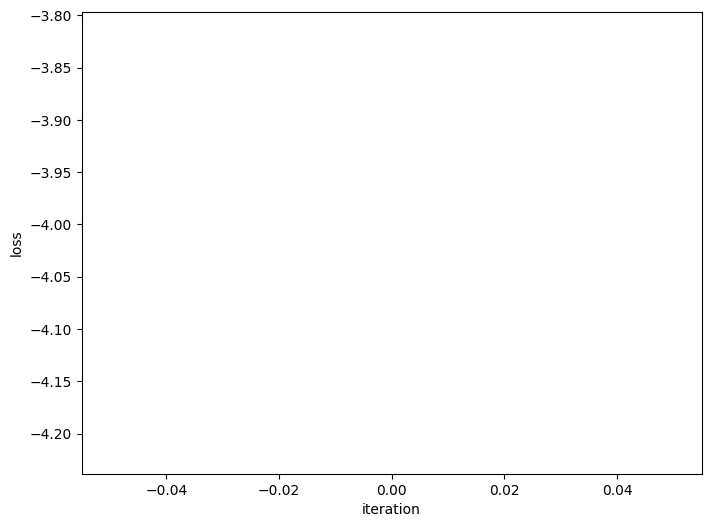

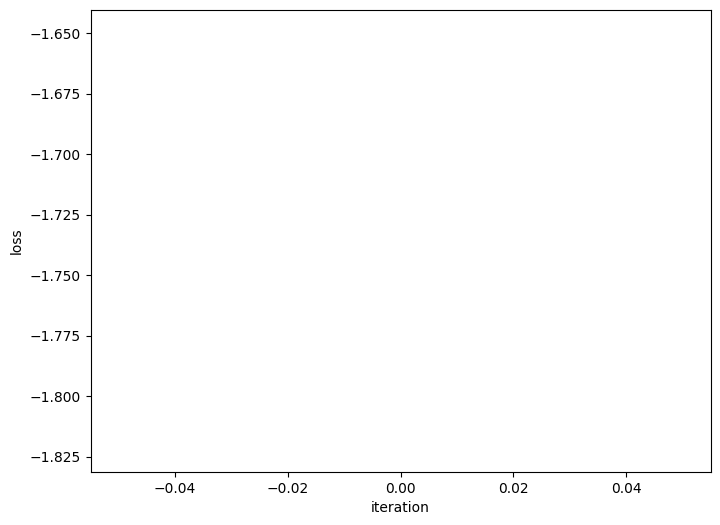

In [12]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [13]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()

weight_alpha 0.2
train_weighted_vae: enc_dec
train: iter 0  trainloss -337.76267  validloss -395.55175±0.00000  bestvalidloss -395.55175  last_update 0
train: iter 1  trainloss -345.12851  validloss -394.24412±0.00000  bestvalidloss -395.55175  last_update 1
train: iter 2  trainloss -343.41090  validloss -391.11302±0.00000  bestvalidloss -395.55175  last_update 2
train: iter 3  trainloss -343.30816  validloss -387.10531±0.00000  bestvalidloss -395.55175  last_update 3
train: iter 4  trainloss -345.67099  validloss -390.35275±0.00000  bestvalidloss -395.55175  last_update 4
train: iter 5  trainloss -344.99930  validloss -401.91298±0.00000  bestvalidloss -401.91298  last_update 0
train: iter 6  trainloss -347.14790  validloss -380.68513±0.00000  bestvalidloss -401.91298  last_update 1
train: iter 7  trainloss -348.00524  validloss -385.44188±0.00000  bestvalidloss -401.91298  last_update 2
train: iter 8  trainloss -347.22448  validloss -379.20177±0.00000  bestvalidloss -401.91298  last_u

train: iter 76  trainloss -388.93489  validloss -423.64765±0.00000  bestvalidloss -437.25192  last_update 12
train: iter 77  trainloss -388.36769  validloss -434.30599±0.00000  bestvalidloss -437.25192  last_update 13
train: iter 78  trainloss -381.36956  validloss -431.88678±0.00000  bestvalidloss -437.25192  last_update 14
train: iter 79  trainloss -388.19359  validloss -418.19572±0.00000  bestvalidloss -437.25192  last_update 15
train: iter 80  trainloss -385.90534  validloss -433.99652±0.00000  bestvalidloss -437.25192  last_update 16
train: iter 81  trainloss -391.19123  validloss -439.09158±0.00000  bestvalidloss -439.09158  last_update 0
train: iter 82  trainloss -393.42442  validloss -426.49672±0.00000  bestvalidloss -439.09158  last_update 1
train: iter 83  trainloss -388.38836  validloss -403.46786±0.00000  bestvalidloss -439.09158  last_update 2
train: iter 84  trainloss -394.30613  validloss -437.38233±0.00000  bestvalidloss -439.09158  last_update 3
train: iter 85  trainlo

train: iter 152  trainloss -425.88736  validloss -193.51964±0.00000  bestvalidloss -464.30758  last_update 4
train: iter 153  trainloss -429.82189  validloss -99.02334±0.00000  bestvalidloss -464.30758  last_update 5
train: iter 154  trainloss -427.78937  validloss -184.02528±0.00000  bestvalidloss -464.30758  last_update 6
train: iter 155  trainloss -429.97775  validloss -465.38609±0.00000  bestvalidloss -465.38609  last_update 0
train: iter 156  trainloss -429.81871  validloss -464.84408±0.00000  bestvalidloss -465.38609  last_update 1
train: iter 157  trainloss -429.35396  validloss -457.27177±0.00000  bestvalidloss -465.38609  last_update 2
train: iter 158  trainloss -434.08069  validloss -435.20015±0.00000  bestvalidloss -465.38609  last_update 3
train: iter 159  trainloss -428.36287  validloss -470.33879±0.00000  bestvalidloss -470.33879  last_update 0
train: iter 160  trainloss -431.75886  validloss -432.84114±0.00000  bestvalidloss -470.33879  last_update 1
train: iter 161  tra

train: iter 227  trainloss -450.45581  validloss -480.92038±0.00000  bestvalidloss -493.23802  last_update 14
train: iter 228  trainloss -454.09680  validloss -482.49502±0.00000  bestvalidloss -493.23802  last_update 15
train: iter 229  trainloss -451.98157  validloss -483.74276±0.00000  bestvalidloss -493.23802  last_update 16
train: iter 230  trainloss -441.26523  validloss -440.43490±0.00000  bestvalidloss -493.23802  last_update 17
train: iter 231  trainloss -456.98783  validloss -478.18001±0.00000  bestvalidloss -493.23802  last_update 18
train: iter 232  trainloss -453.49611  validloss -481.64330±0.00000  bestvalidloss -493.23802  last_update 19
train: iter 233  trainloss -452.16609  validloss -494.16368±0.00000  bestvalidloss -494.16368  last_update 0
train: iter 234  trainloss -457.44622  validloss -477.43216±0.00000  bestvalidloss -494.16368  last_update 1
train: iter 235  trainloss -454.72426  validloss -496.22225±0.00000  bestvalidloss -496.22225  last_update 0
train: iter 2

train: iter 302  trainloss -470.70645  validloss -497.52512±0.00000  bestvalidloss -515.64274  last_update 11
train: iter 303  trainloss -465.89401  validloss -511.38615±0.00000  bestvalidloss -515.64274  last_update 12
train: iter 304  trainloss -470.92630  validloss -512.33655±0.00000  bestvalidloss -515.64274  last_update 13
train: iter 305  trainloss -474.98119  validloss -509.43663±0.00000  bestvalidloss -515.64274  last_update 14
train: iter 306  trainloss -463.01739  validloss -416.83004±0.00000  bestvalidloss -515.64274  last_update 15
train: iter 307  trainloss -465.56304  validloss -482.74664±0.00000  bestvalidloss -515.64274  last_update 16
train: iter 308  trainloss -471.36829  validloss -489.57775±0.00000  bestvalidloss -515.64274  last_update 17
train: iter 309  trainloss -454.98131  validloss -472.96295±0.00000  bestvalidloss -515.64274  last_update 18
train: iter 310  trainloss -466.92507  validloss -517.79978±0.00000  bestvalidloss -517.79978  last_update 0
train: iter

train: iter 377  trainloss -482.96181  validloss -503.38220±0.00000  bestvalidloss -532.00075  last_update 9
train: iter 378  trainloss -485.88611  validloss -519.93282±0.00000  bestvalidloss -532.00075  last_update 10
train: iter 379  trainloss -485.00135  validloss -524.18376±0.00000  bestvalidloss -532.00075  last_update 11
train: iter 380  trainloss -483.61455  validloss -506.40125±0.00000  bestvalidloss -532.00075  last_update 12
train: iter 381  trainloss -480.63636  validloss -529.76167±0.00000  bestvalidloss -532.00075  last_update 13
train: iter 382  trainloss -477.97713  validloss -501.89271±0.00000  bestvalidloss -532.00075  last_update 14
train: iter 383  trainloss -471.87308  validloss -503.33083±0.00000  bestvalidloss -532.00075  last_update 15
train: iter 384  trainloss -477.92177  validloss -516.54664±0.00000  bestvalidloss -532.00075  last_update 16
train: iter 385  trainloss -487.64212  validloss -531.28849±0.00000  bestvalidloss -532.00075  last_update 17
train: iter

train: iter 452  trainloss -489.98944  validloss -511.55490±0.00000  bestvalidloss -539.82801  last_update 37
train: iter 453  trainloss -485.29299  validloss -462.23735±0.00000  bestvalidloss -539.82801  last_update 38
train: iter 454  trainloss -483.38554  validloss -504.86052±0.00000  bestvalidloss -539.82801  last_update 39
train: iter 455  trainloss -451.77894  validloss -512.12921±0.00000  bestvalidloss -539.82801  last_update 40
train: iter 456  trainloss -489.85236  validloss -514.22614±0.00000  bestvalidloss -539.82801  last_update 41
train: iter 457  trainloss -489.04733  validloss -537.52649±0.00000  bestvalidloss -539.82801  last_update 42
train: iter 458  trainloss -492.02972  validloss -513.11279±0.00000  bestvalidloss -539.82801  last_update 43
train: iter 459  trainloss -487.83936  validloss -512.30541±0.00000  bestvalidloss -539.82801  last_update 44
train: iter 460  trainloss -490.98035  validloss -485.86086±0.00000  bestvalidloss -539.82801  last_update 45
train: ite

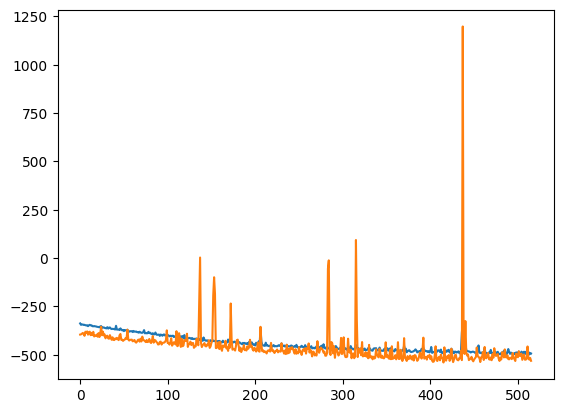

alpha 0.2 default_lr 0.0005


In [14]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
    print("alpha",alpha, "default_lr", default_lr)

In [15]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [16]:
print(datetime.datetime.now())

2023-08-19 08:48:19.105893


# Iter2

In [17]:
policy_evaluation_iter=1

In [18]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [19]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.13992  validloss 2.22901±0.00000  bestvalidloss 2.22901  last_update 0
train: iter 1  trainloss 0.72438  validloss 0.74335±0.00000  bestvalidloss 0.74335  last_update 0
train: iter 2  trainloss 0.63790  validloss 0.62944±0.00000  bestvalidloss 0.62944  last_update 0
train: iter 3  trainloss 0.60547  validloss 0.60035±0.00000  bestvalidloss 0.60035  last_update 0
train: iter 4  trainloss 0.57495  validloss 0.56537±0.00000  bestvalidloss 0.56537  last_update 0
train: iter 5  trainloss 0.55877  validloss 0.56339±0.00000  bestvalidloss 0.56339  last_update 0
train: iter 6  trainloss 0.53533  validloss 0.54489±0.00000  bestvalidloss 0.54489  last_update 0
train: iter 7  trainloss 0.52333  validloss 0.54728±0.00000  bestvalidloss 0.54489  last_update 1
train: iter 8  trainloss 0.50621  validloss 0.54562±0.00000  bestvalidloss 0.54489  last_update 2
train: iter 9  trainloss 0.49502  validloss 0.53491±0.00000  bestvalidloss 0.53491  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.39127  validloss 0.46418±0.00000  bestvalidloss 0.46211  last_update 2
train: iter 84  trainloss 0.39353  validloss 0.46347±0.00000  bestvalidloss 0.46211  last_update 3
train: iter 85  trainloss 0.39115  validloss 0.46869±0.00000  bestvalidloss 0.46211  last_update 4
train: iter 86  trainloss 0.39508  validloss 0.45848±0.00000  bestvalidloss 0.45848  last_update 0
train: iter 87  trainloss 0.38734  validloss 0.47232±0.00000  bestvalidloss 0.45848  last_update 1
train: iter 88  trainloss 0.38841  validloss 0.47137±0.00000  bestvalidloss 0.45848  last_update 2
train: iter 89  trainloss 0.39339  validloss 0.50176±0.00000  bestvalidloss 0.45848  last_update 3
train: iter 90  trainloss 0.38446  validloss 0.46908±0.00000  bestvalidloss 0.45848  last_update 4
train: iter 91  trainloss 0.38909  validloss 0.47675±0.00000  bestvalidloss 0.45848  last_update 5
train: iter 92  trainloss 0.39624  validloss 0.49694±0.00000  bestvalidloss 0.45848  last_update 6
train: ite

train: iter 165  trainloss 0.36360  validloss 0.49383±0.00000  bestvalidloss 0.45848  last_update 79
train: iter 166  trainloss 0.35593  validloss 0.47828±0.00000  bestvalidloss 0.45848  last_update 80
train: iter 167  trainloss 0.35782  validloss 0.46573±0.00000  bestvalidloss 0.45848  last_update 81
train: iter 168  trainloss 0.35696  validloss 0.47325±0.00000  bestvalidloss 0.45848  last_update 82
train: iter 169  trainloss 0.36129  validloss 0.46878±0.00000  bestvalidloss 0.45848  last_update 83
train: iter 170  trainloss 0.35938  validloss 0.47722±0.00000  bestvalidloss 0.45848  last_update 84
train: iter 171  trainloss 0.35680  validloss 0.48048±0.00000  bestvalidloss 0.45848  last_update 85
train: iter 172  trainloss 0.35747  validloss 0.46743±0.00000  bestvalidloss 0.45848  last_update 86
train: iter 173  trainloss 0.35816  validloss 0.46678±0.00000  bestvalidloss 0.45848  last_update 87
train: iter 174  trainloss 0.35517  validloss 0.47495±0.00000  bestvalidloss 0.45848  last_

train_loss:  -5.923476006126403
valid_loss:  -7.910701337718963
weight_alpha 1.0 h_min_tilde -11.720267 ell_tilde -6.320921072444915 kappa_tilde 0.00021517876766920677
train_loss:  -2.621471824969351
valid_loss:  -2.4732504958152766
weight_alpha 0.2 h_min_tilde -11.720267 ell_tilde -2.5918275591385362 kappa_tilde 0.00016548998931747882


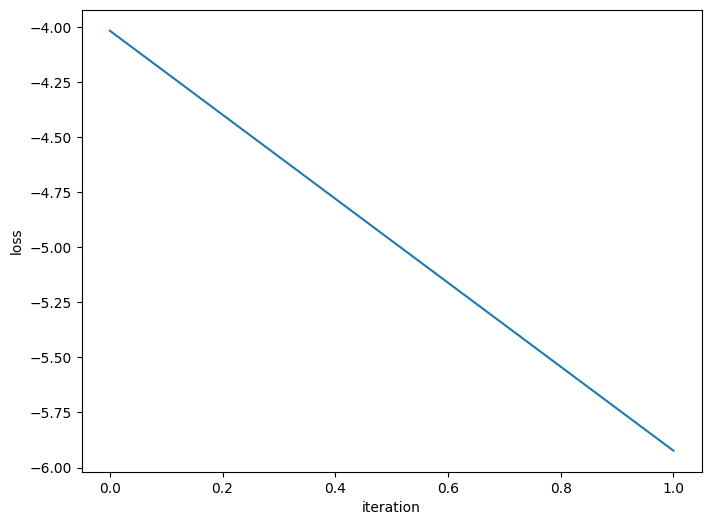

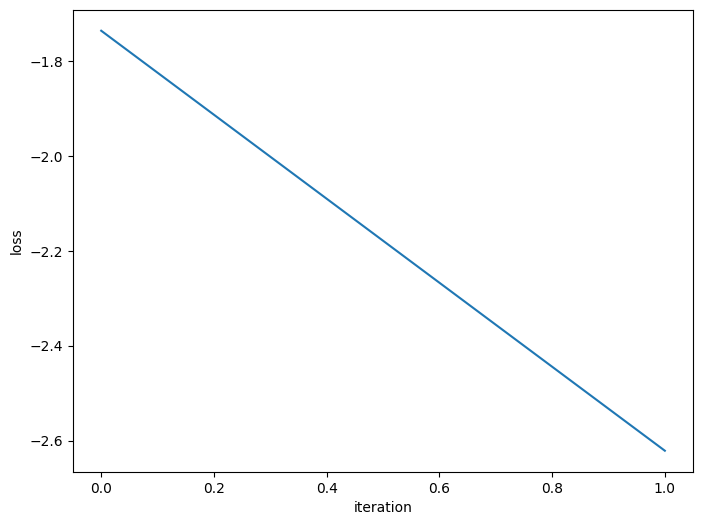

In [20]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [21]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.2
train_weighted_vae: enc_dec
train: iter 0  trainloss -522.82103  validloss -496.21146±0.00000  bestvalidloss -496.21146  last_update 0
train: iter 1  trainloss -517.08775  validloss -505.23100±0.00000  bestvalidloss -505.23100  last_update 0
train: iter 2  trainloss -520.63579  validloss -554.95243±0.00000  bestvalidloss -554.95243  last_update 0
train: iter 3  trainloss -523.34529  validloss -508.23003±0.00000  bestvalidloss -554.95243  last_update 1
train: iter 4  trainloss -525.73957  validloss -495.44351±0.00000  bestvalidloss -554.95243  last_update 2
train: iter 5  trainloss -509.16333  validloss -544.72844±0.00000  bestvalidloss -554.95243  last_update 3
train: iter 6  trainloss -514.84779  validloss 272.79166±0.00000  bestvalidloss -554.95243  last_update 4
train: iter 7  trainloss -526.64400  validloss -489.25058±0.00000  bestvalidloss -554.95243  last_update 5
train: iter 8  trainloss -519.04226  validloss -531.94430±0.00000  bestvalidloss -554.95243  last_up

train: iter 76  trainloss -538.03989  validloss -521.20935±0.00000  bestvalidloss -563.65628  last_update 16
train: iter 77  trainloss -548.31359  validloss -536.96227±0.00000  bestvalidloss -563.65628  last_update 17
train: iter 78  trainloss -540.70746  validloss -548.36626±0.00000  bestvalidloss -563.65628  last_update 18
train: iter 79  trainloss -520.15348  validloss -517.00798±0.00000  bestvalidloss -563.65628  last_update 19
train: iter 80  trainloss -548.99543  validloss -559.16020±0.00000  bestvalidloss -563.65628  last_update 20
train: iter 81  trainloss -533.01951  validloss -533.00862±0.00000  bestvalidloss -563.65628  last_update 21
train: iter 82  trainloss -542.28973  validloss -531.41982±0.00000  bestvalidloss -563.65628  last_update 22
train: iter 83  trainloss -531.71568  validloss -353.36669±0.00000  bestvalidloss -563.65628  last_update 23
train: iter 84  trainloss -547.61906  validloss -551.08042±0.00000  bestvalidloss -563.65628  last_update 24
train: iter 85  tra

train: iter 151  trainloss -529.76913  validloss -549.12394±0.00000  bestvalidloss -569.91142  last_update 37
train: iter 152  trainloss -537.12181  validloss -514.80437±0.00000  bestvalidloss -569.91142  last_update 38
train: iter 153  trainloss -545.98574  validloss -531.80133±0.00000  bestvalidloss -569.91142  last_update 39
train: iter 154  trainloss -541.08168  validloss -494.25844±0.00000  bestvalidloss -569.91142  last_update 40
train: iter 155  trainloss -534.17152  validloss -527.08670±0.00000  bestvalidloss -569.91142  last_update 41
train: iter 156  trainloss -509.81340  validloss -535.17776±0.00000  bestvalidloss -569.91142  last_update 42
train: iter 157  trainloss -545.49880  validloss -512.67740±0.00000  bestvalidloss -569.91142  last_update 43
train: iter 158  trainloss -544.86759  validloss -537.43681±0.00000  bestvalidloss -569.91142  last_update 44
train: iter 159  trainloss -533.31001  validloss -534.06518±0.00000  bestvalidloss -569.91142  last_update 45
train: ite

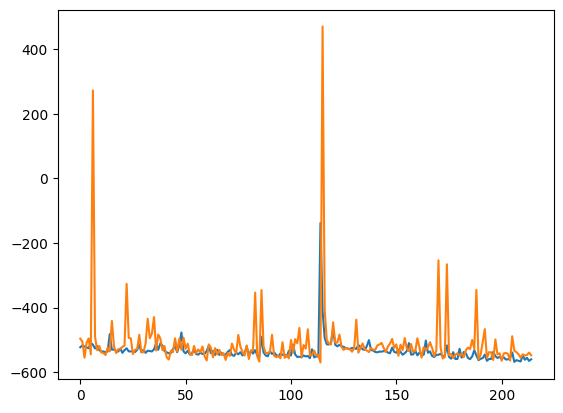

alpha 0.2 default_lr 0.0005


In [22]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [23]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)


In [24]:
print(datetime.datetime.now())

2023-08-19 09:14:13.319234


In [25]:
# if policy_evaluation_iter<policy_evaluation_maxiter:
#     normalized_loss_array = np.array(normalized_loss_list)
#     plt.figure(figsize=(16,12))
#     plt.plot(normalized_loss_array[:,0])
#     plt.xlabel("iteration")
#     plt.ylabel("loss")


# Iter 3

In [26]:
policy_evaluation_iter=2

In [27]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9
predict diverge [ -2.74034849  -1.81678347 -14.96589473  43.37344556] [-0.23360725  2.24319377  1.31377192 14.49311207] [146.79016   23.436619 198.34738   31.218063] [73.39508  11.718309 99.17369  15.609032] sim_timestep 142

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76
predict diverge [-4.93522825 -6.8216381  -6.98875047 35.23974762] [-0.30832122  0.19210797  1.21134691  9.0420631 ] [146.79016   23.436619 198.34738   31.218063] [73.39508  11.718309 99.17369  15.609032] sim_timestep 119

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [28]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.54920  validloss 0.86997±0.00000  bestvalidloss 0.86997  last_update 0
train: iter 1  trainloss 0.48521  validloss 0.68751±0.00000  bestvalidloss 0.68751  last_update 0
train: iter 2  trainloss 0.47741  validloss 0.65975±0.00000  bestvalidloss 0.65975  last_update 0
train: iter 3  trainloss 0.46817  validloss 0.64677±0.00000  bestvalidloss 0.64677  last_update 0
train: iter 4  trainloss 0.46576  validloss 0.64088±0.00000  bestvalidloss 0.64088  last_update 0
train: iter 5  trainloss 0.45632  validloss 0.63401±0.00000  bestvalidloss 0.63401  last_update 0
train: iter 6  trainloss 0.45237  validloss 0.62897±0.00000  bestvalidloss 0.62897  last_update 0
train: iter 7  trainloss 0.44587  validloss 0.62238±0.00000  bestvalidloss 0.62238  last_update 0
train: iter 8  trainloss 0.44470  validloss 0.62662±0.00000  bestvalidloss 0.62238  last_update 1
train: iter 9  trainloss 0.44049  validloss 0.61859±0.00000  bestvalidloss 0.61859  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.38458  validloss 0.59961±0.00000  bestvalidloss 0.56425  last_update 12
train: iter 84  trainloss 0.38353  validloss 0.56855±0.00000  bestvalidloss 0.56425  last_update 13
train: iter 85  trainloss 0.38819  validloss 0.57347±0.00000  bestvalidloss 0.56425  last_update 14
train: iter 86  trainloss 0.38557  validloss 0.57301±0.00000  bestvalidloss 0.56425  last_update 15
train: iter 87  trainloss 0.38209  validloss 0.56921±0.00000  bestvalidloss 0.56425  last_update 16
train: iter 88  trainloss 0.38282  validloss 0.56926±0.00000  bestvalidloss 0.56425  last_update 17
train: iter 89  trainloss 0.38384  validloss 0.58069±0.00000  bestvalidloss 0.56425  last_update 18
train: iter 90  trainloss 0.38212  validloss 0.59558±0.00000  bestvalidloss 0.56425  last_update 19
train: iter 91  trainloss 0.37956  validloss 0.59692±0.00000  bestvalidloss 0.56425  last_update 20
train: iter 92  trainloss 0.37973  validloss 0.57336±0.00000  bestvalidloss 0.56425  last_update 21


train: iter 165  trainloss 0.36538  validloss 0.57817±0.00000  bestvalidloss 0.54942  last_update 15
train: iter 166  trainloss 0.36270  validloss 0.56674±0.00000  bestvalidloss 0.54942  last_update 16
train: iter 167  trainloss 0.36306  validloss 0.56166±0.00000  bestvalidloss 0.54942  last_update 17
train: iter 168  trainloss 0.36794  validloss 0.55621±0.00000  bestvalidloss 0.54942  last_update 18
train: iter 169  trainloss 0.36464  validloss 0.57799±0.00000  bestvalidloss 0.54942  last_update 19
train: iter 170  trainloss 0.36527  validloss 0.56577±0.00000  bestvalidloss 0.54942  last_update 20
train: iter 171  trainloss 0.36899  validloss 0.54971±0.00000  bestvalidloss 0.54942  last_update 21
train: iter 172  trainloss 0.36052  validloss 0.55967±0.00000  bestvalidloss 0.54942  last_update 22
train: iter 173  trainloss 0.36389  validloss 0.54872±0.00000  bestvalidloss 0.54872  last_update 0
train: iter 174  trainloss 0.36589  validloss 0.55584±0.00000  bestvalidloss 0.54872  last_u

train: iter 247  trainloss 0.35488  validloss 0.55442±0.00000  bestvalidloss 0.54690  last_update 20
train: iter 248  trainloss 0.35069  validloss 0.56687±0.00000  bestvalidloss 0.54690  last_update 21
train: iter 249  trainloss 0.35569  validloss 0.59050±0.00000  bestvalidloss 0.54690  last_update 22
train: iter 250  trainloss 0.35313  validloss 0.55247±0.00000  bestvalidloss 0.54690  last_update 23
train: iter 251  trainloss 0.35371  validloss 0.55995±0.00000  bestvalidloss 0.54690  last_update 24
train: iter 252  trainloss 0.35241  validloss 0.55395±0.00000  bestvalidloss 0.54690  last_update 25
train: iter 253  trainloss 0.34772  validloss 0.55643±0.00000  bestvalidloss 0.54690  last_update 26
train: iter 254  trainloss 0.35184  validloss 0.59350±0.00000  bestvalidloss 0.54690  last_update 27
train: iter 255  trainloss 0.35349  validloss 0.55952±0.00000  bestvalidloss 0.54690  last_update 28
train: iter 256  trainloss 0.35107  validloss 0.56359±0.00000  bestvalidloss 0.54690  last_

train: iter 329  trainloss 0.34624  validloss 0.55754±0.00000  bestvalidloss 0.54571  last_update 44
train: iter 330  trainloss 0.34123  validloss 0.56024±0.00000  bestvalidloss 0.54571  last_update 45
train: iter 331  trainloss 0.34508  validloss 0.58112±0.00000  bestvalidloss 0.54571  last_update 46
train: iter 332  trainloss 0.34179  validloss 0.56016±0.00000  bestvalidloss 0.54571  last_update 47
train: iter 333  trainloss 0.34496  validloss 0.57037±0.00000  bestvalidloss 0.54571  last_update 48
train: iter 334  trainloss 0.34465  validloss 0.58330±0.00000  bestvalidloss 0.54571  last_update 49
train: iter 335  trainloss 0.34169  validloss 0.56920±0.00000  bestvalidloss 0.54571  last_update 50
train: iter 336  trainloss 0.34228  validloss 0.55487±0.00000  bestvalidloss 0.54571  last_update 51
train: iter 337  trainloss 0.34203  validloss 0.56236±0.00000  bestvalidloss 0.54571  last_update 52
train: iter 338  trainloss 0.34326  validloss 0.56072±0.00000  bestvalidloss 0.54571  last_

train_loss:  -4.965658436110616
valid_loss:  -7.625369073724746
weight_alpha 1.0 h_min_tilde -11.616926 ell_tilde -5.497600563633442 kappa_tilde 0.00020212415732629064
train_loss:  -2.7026537763357164
valid_loss:  -2.430884396839142
weight_alpha 0.2 h_min_tilde -11.616926 ell_tilde -2.648299900436401 kappa_tilde 0.00016695792566669322


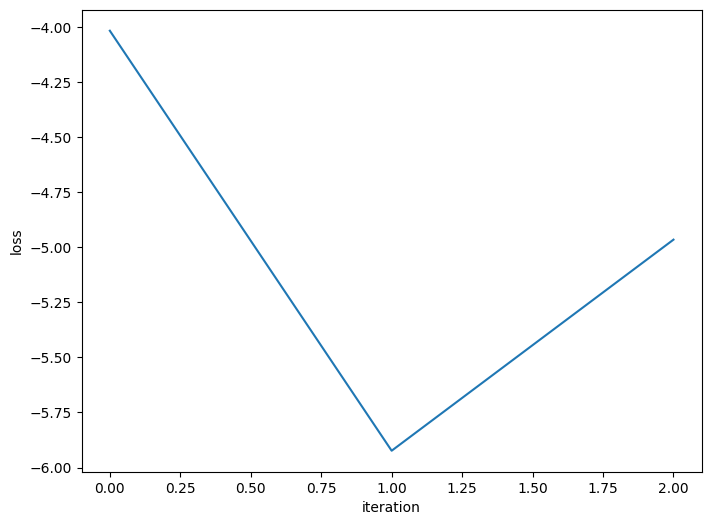

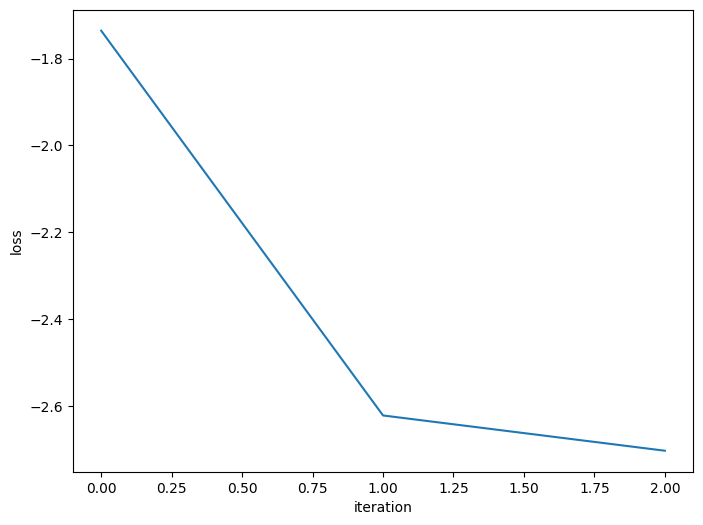

In [29]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")


In [30]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.2
train_weighted_vae: enc_dec
train: iter 0  trainloss -545.84433  validloss -483.01673±0.00000  bestvalidloss -483.01673  last_update 0
train: iter 1  trainloss -552.57800  validloss -470.31809±0.00000  bestvalidloss -483.01673  last_update 1
train: iter 2  trainloss -554.50647  validloss -494.42024±0.00000  bestvalidloss -494.42024  last_update 0
train: iter 3  trainloss -557.31787  validloss -492.82058±0.00000  bestvalidloss -494.42024  last_update 1
train: iter 4  trainloss -555.74311  validloss -424.84579±0.00000  bestvalidloss -494.42024  last_update 2
train: iter 5  trainloss -546.53862  validloss -529.45881±0.00000  bestvalidloss -529.45881  last_update 0
train: iter 6  trainloss -545.79568  validloss -515.43443±0.00000  bestvalidloss -529.45881  last_update 1
train: iter 7  trainloss -562.23117  validloss -518.04082±0.00000  bestvalidloss -529.45881  last_update 2
train: iter 8  trainloss -542.01577  validloss -481.43857±0.00000  bestvalidloss -529.45881  last_u

train: iter 76  trainloss -563.79952  validloss -455.13295±0.00000  bestvalidloss -564.96270  last_update 40
train: iter 77  trainloss -571.34368  validloss -537.67677±0.00000  bestvalidloss -564.96270  last_update 41
train: iter 78  trainloss -577.50576  validloss -548.71059±0.00000  bestvalidloss -564.96270  last_update 42
train: iter 79  trainloss -533.34850  validloss -463.75018±0.00000  bestvalidloss -564.96270  last_update 43
train: iter 80  trainloss -567.46987  validloss -490.79588±0.00000  bestvalidloss -564.96270  last_update 44
train: iter 81  trainloss -579.34478  validloss -524.87853±0.00000  bestvalidloss -564.96270  last_update 45
train: iter 82  trainloss -584.24721  validloss -532.00397±0.00000  bestvalidloss -564.96270  last_update 46
train: iter 83  trainloss -578.84582  validloss -520.82921±0.00000  bestvalidloss -564.96270  last_update 47
train: iter 84  trainloss -574.53850  validloss -536.45465±0.00000  bestvalidloss -564.96270  last_update 48
train: iter 85  tra

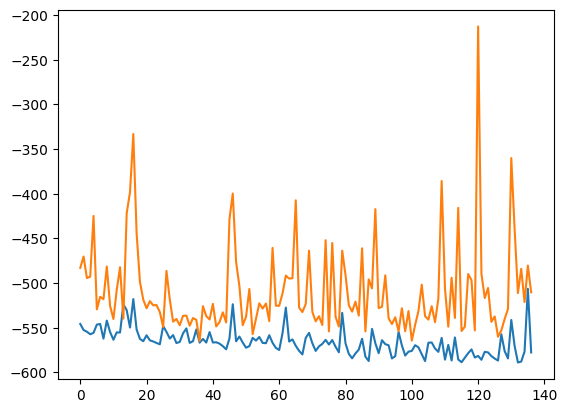

alpha 0.2 default_lr 0.0005


In [31]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [32]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [33]:
print(datetime.datetime.now())

2023-08-19 09:39:50.852785


# Iter 4

In [34]:
policy_evaluation_iter=3

In [35]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [36]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.51628  validloss 0.81059±0.00000  bestvalidloss 0.81059  last_update 0
train: iter 1  trainloss 0.47093  validloss 0.64948±0.00000  bestvalidloss 0.64948  last_update 0
train: iter 2  trainloss 0.45999  validloss 0.61388±0.00000  bestvalidloss 0.61388  last_update 0
train: iter 3  trainloss 0.45523  validloss 0.58696±0.00000  bestvalidloss 0.58696  last_update 0
train: iter 4  trainloss 0.44867  validloss 0.58166±0.00000  bestvalidloss 0.58166  last_update 0
train: iter 5  trainloss 0.44091  validloss 0.57459±0.00000  bestvalidloss 0.57459  last_update 0
train: iter 6  trainloss 0.43582  validloss 0.56765±0.00000  bestvalidloss 0.56765  last_update 0
train: iter 7  trainloss 0.43752  validloss 0.53807±0.00000  bestvalidloss 0.53807  last_update 0
train: iter 8  trainloss 0.43418  validloss 0.53552±0.00000  bestvalidloss 0.53552  last_update 0
train: iter 9  trainloss 0.43250  validloss 0.54092±0.00000  bestvalidloss 0.53552  last_update 1
train: iter 10  trai

train: iter 83  trainloss 0.38754  validloss 0.50498±0.00000  bestvalidloss 0.49997  last_update 17
train: iter 84  trainloss 0.38635  validloss 0.49690±0.00000  bestvalidloss 0.49690  last_update 0
train: iter 85  trainloss 0.39096  validloss 0.49984±0.00000  bestvalidloss 0.49690  last_update 1
train: iter 86  trainloss 0.39134  validloss 0.50093±0.00000  bestvalidloss 0.49690  last_update 2
train: iter 87  trainloss 0.39223  validloss 0.51328±0.00000  bestvalidloss 0.49690  last_update 3
train: iter 88  trainloss 0.38687  validloss 0.54713±0.00000  bestvalidloss 0.49690  last_update 4
train: iter 89  trainloss 0.38541  validloss 0.50167±0.00000  bestvalidloss 0.49690  last_update 5
train: iter 90  trainloss 0.38505  validloss 0.49850±0.00000  bestvalidloss 0.49690  last_update 6
train: iter 91  trainloss 0.38870  validloss 0.52440±0.00000  bestvalidloss 0.49690  last_update 7
train: iter 92  trainloss 0.38861  validloss 0.50877±0.00000  bestvalidloss 0.49690  last_update 8
train: it

train: iter 165  trainloss 0.37629  validloss 0.49749±0.00000  bestvalidloss 0.48936  last_update 24
train: iter 166  trainloss 0.37367  validloss 0.49566±0.00000  bestvalidloss 0.48936  last_update 25
train: iter 167  trainloss 0.37312  validloss 0.50184±0.00000  bestvalidloss 0.48936  last_update 26
train: iter 168  trainloss 0.37713  validloss 0.49610±0.00000  bestvalidloss 0.48936  last_update 27
train: iter 169  trainloss 0.37413  validloss 0.49977±0.00000  bestvalidloss 0.48936  last_update 28
train: iter 170  trainloss 0.37160  validloss 0.49479±0.00000  bestvalidloss 0.48936  last_update 29
train: iter 171  trainloss 0.37275  validloss 0.50297±0.00000  bestvalidloss 0.48936  last_update 30
train: iter 172  trainloss 0.37745  validloss 0.49355±0.00000  bestvalidloss 0.48936  last_update 31
train: iter 173  trainloss 0.37344  validloss 0.51855±0.00000  bestvalidloss 0.48936  last_update 32
train: iter 174  trainloss 0.37507  validloss 0.49467±0.00000  bestvalidloss 0.48936  last_

train: iter 247  trainloss 0.36784  validloss 0.50720±0.00000  bestvalidloss 0.48235  last_update 30
train: iter 248  trainloss 0.36456  validloss 0.48888±0.00000  bestvalidloss 0.48235  last_update 31
train: iter 249  trainloss 0.36766  validloss 0.48456±0.00000  bestvalidloss 0.48235  last_update 32
train: iter 250  trainloss 0.36637  validloss 0.48403±0.00000  bestvalidloss 0.48235  last_update 33
train: iter 251  trainloss 0.36451  validloss 0.49923±0.00000  bestvalidloss 0.48235  last_update 34
train: iter 252  trainloss 0.36757  validloss 0.49490±0.00000  bestvalidloss 0.48235  last_update 35
train: iter 253  trainloss 0.36724  validloss 0.48801±0.00000  bestvalidloss 0.48235  last_update 36
train: iter 254  trainloss 0.36533  validloss 0.48957±0.00000  bestvalidloss 0.48235  last_update 37
train: iter 255  trainloss 0.36781  validloss 0.49511±0.00000  bestvalidloss 0.48235  last_update 38
train: iter 256  trainloss 0.36339  validloss 0.51721±0.00000  bestvalidloss 0.48235  last_

train_loss:  -5.212211033537983
valid_loss:  -6.517511293983459
weight_alpha 1.0 h_min_tilde -11.625298 ell_tilde -5.473271085627078 kappa_tilde 0.0002015862504509767
train_loss:  -2.8481238144695764
valid_loss:  -2.574964116001129
weight_alpha 0.2 h_min_tilde -11.625298 ell_tilde -2.7934918747758872 kappa_tilde 0.00016824619534380934


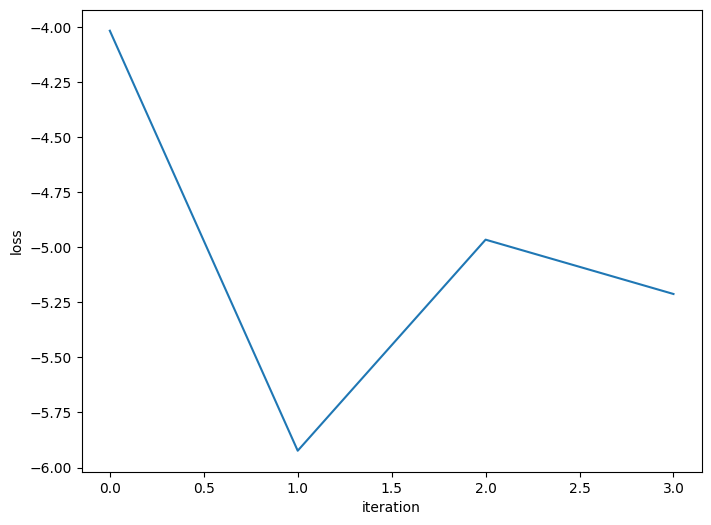

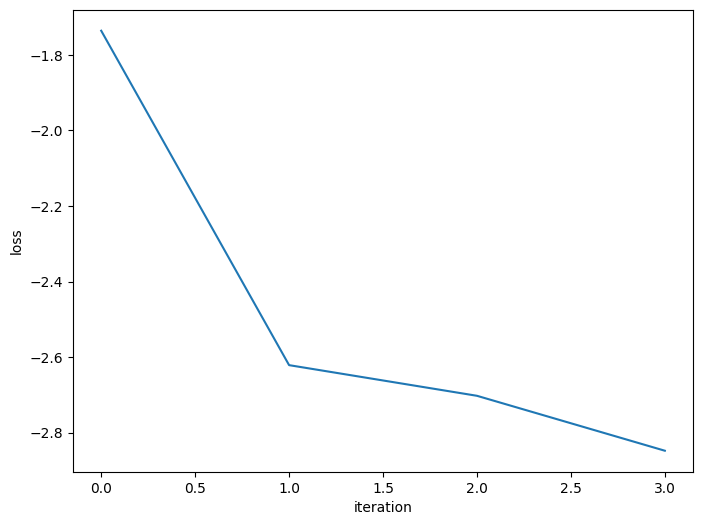

In [37]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [38]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.2
train_weighted_vae: enc_dec
train: iter 0  trainloss -568.99414  validloss -511.16543±0.00000  bestvalidloss -511.16543  last_update 0
train: iter 1  trainloss -580.69677  validloss -523.84201±0.00000  bestvalidloss -523.84201  last_update 0
train: iter 2  trainloss -587.72672  validloss -549.68769±0.00000  bestvalidloss -549.68769  last_update 0
train: iter 3  trainloss -567.42495  validloss -482.28342±0.00000  bestvalidloss -549.68769  last_update 1
train: iter 4  trainloss -581.85524  validloss -531.06295±0.00000  bestvalidloss -549.68769  last_update 2
train: iter 5  trainloss -579.61071  validloss -517.62265±0.00000  bestvalidloss -549.68769  last_update 3
train: iter 6  trainloss -580.66484  validloss -507.89655±0.00000  bestvalidloss -549.68769  last_update 4
train: iter 7  trainloss -575.76307  validloss -536.78484±0.00000  bestvalidloss -549.68769  last_update 5
train: iter 8  trainloss -583.48340  validloss -526.59014±0.00000  bestvalidloss -549.68769  last_u

train: iter 76  trainloss -577.14810  validloss -525.57225±0.00000  bestvalidloss -574.19691  last_update 15
train: iter 77  trainloss -587.45383  validloss -526.87373±0.00000  bestvalidloss -574.19691  last_update 16
train: iter 78  trainloss -593.11375  validloss -554.91670±0.00000  bestvalidloss -574.19691  last_update 17
train: iter 79  trainloss -594.88083  validloss -553.50721±0.00000  bestvalidloss -574.19691  last_update 18
train: iter 80  trainloss -596.57997  validloss -561.39023±0.00000  bestvalidloss -574.19691  last_update 19
train: iter 81  trainloss -586.70931  validloss -545.15796±0.00000  bestvalidloss -574.19691  last_update 20
train: iter 82  trainloss -589.77536  validloss -528.58807±0.00000  bestvalidloss -574.19691  last_update 21
train: iter 83  trainloss -575.57044  validloss -477.38430±0.00000  bestvalidloss -574.19691  last_update 22
train: iter 84  trainloss -592.18380  validloss -501.00069±0.00000  bestvalidloss -574.19691  last_update 23
train: iter 85  tra

train: iter 151  trainloss -596.09178  validloss -576.99163±0.00000  bestvalidloss -576.99163  last_update 0
train: iter 152  trainloss -608.37945  validloss -561.09309±0.00000  bestvalidloss -576.99163  last_update 1
train: iter 153  trainloss -608.13835  validloss -538.61160±0.00000  bestvalidloss -576.99163  last_update 2
train: iter 154  trainloss -606.28752  validloss -473.71349±0.00000  bestvalidloss -576.99163  last_update 3
train: iter 155  trainloss -601.74763  validloss -552.02455±0.00000  bestvalidloss -576.99163  last_update 4
train: iter 156  trainloss -601.19393  validloss -528.49542±0.00000  bestvalidloss -576.99163  last_update 5
train: iter 157  trainloss -612.43069  validloss -562.16346±0.00000  bestvalidloss -576.99163  last_update 6
train: iter 158  trainloss -607.54048  validloss -531.70598±0.00000  bestvalidloss -576.99163  last_update 7
train: iter 159  trainloss -582.86896  validloss -546.02701±0.00000  bestvalidloss -576.99163  last_update 8
train: iter 160  tr

train: iter 226  trainloss -621.14893  validloss -572.13328±0.00000  bestvalidloss -584.91508  last_update 19
train: iter 227  trainloss -618.05021  validloss -553.47897±0.00000  bestvalidloss -584.91508  last_update 20
train: iter 228  trainloss -623.06205  validloss -546.47289±0.00000  bestvalidloss -584.91508  last_update 21
train: iter 229  trainloss -618.39011  validloss -534.21785±0.00000  bestvalidloss -584.91508  last_update 22
train: iter 230  trainloss -623.07518  validloss -577.58114±0.00000  bestvalidloss -584.91508  last_update 23
train: iter 231  trainloss -623.44441  validloss -555.85336±0.00000  bestvalidloss -584.91508  last_update 24
train: iter 232  trainloss -623.64803  validloss -561.50959±0.00000  bestvalidloss -584.91508  last_update 25
train: iter 233  trainloss -611.91541  validloss -505.18303±0.00000  bestvalidloss -584.91508  last_update 26
train: iter 234  trainloss -625.39239  validloss -568.21846±0.00000  bestvalidloss -584.91508  last_update 27
train: ite

train: iter 301  trainloss -628.62334  validloss -581.24746±0.00000  bestvalidloss -610.07225  last_update 4
train: iter 302  trainloss -630.11097  validloss -586.59309±0.00000  bestvalidloss -610.07225  last_update 5
train: iter 303  trainloss -629.20578  validloss -572.43322±0.00000  bestvalidloss -610.07225  last_update 6
train: iter 304  trainloss -616.33400  validloss -573.21221±0.00000  bestvalidloss -610.07225  last_update 7
train: iter 305  trainloss -619.78318  validloss -589.63950±0.00000  bestvalidloss -610.07225  last_update 8
train: iter 306  trainloss -625.55847  validloss -575.82076±0.00000  bestvalidloss -610.07225  last_update 9
train: iter 307  trainloss -625.06315  validloss -570.13105±0.00000  bestvalidloss -610.07225  last_update 10
train: iter 308  trainloss -626.39833  validloss -595.08409±0.00000  bestvalidloss -610.07225  last_update 11
train: iter 309  trainloss -626.28107  validloss -563.38314±0.00000  bestvalidloss -610.07225  last_update 12
train: iter 310 

train: iter 376  trainloss -645.34247  validloss -584.44535±0.00000  bestvalidloss -610.86947  last_update 32
train: iter 377  trainloss -624.27762  validloss -572.64694±0.00000  bestvalidloss -610.86947  last_update 33
train: iter 378  trainloss -634.97991  validloss -579.48850±0.00000  bestvalidloss -610.86947  last_update 34
train: iter 379  trainloss -634.15400  validloss -572.32580±0.00000  bestvalidloss -610.86947  last_update 35
train: iter 380  trainloss -632.45684  validloss -584.50405±0.00000  bestvalidloss -610.86947  last_update 36
train: iter 381  trainloss -634.26847  validloss -594.72089±0.00000  bestvalidloss -610.86947  last_update 37
train: iter 382  trainloss -631.69866  validloss -604.24935±0.00000  bestvalidloss -610.86947  last_update 38
train: iter 383  trainloss -627.35010  validloss -573.27638±0.00000  bestvalidloss -610.86947  last_update 39
train: iter 384  trainloss -619.05462  validloss -571.01155±0.00000  bestvalidloss -610.86947  last_update 40
train: ite

train: iter 451  trainloss -595.08485  validloss -373.79156±0.00000  bestvalidloss -611.71916  last_update 64
train: iter 452  trainloss -602.93640  validloss -555.41159±0.00000  bestvalidloss -611.71916  last_update 65
train: iter 453  trainloss -602.64804  validloss -533.06693±0.00000  bestvalidloss -611.71916  last_update 66
train: iter 454  trainloss -602.12639  validloss -502.40330±0.00000  bestvalidloss -611.71916  last_update 67
train: iter 455  trainloss -602.06739  validloss -566.70849±0.00000  bestvalidloss -611.71916  last_update 68
train: iter 456  trainloss -600.83503  validloss -535.64553±0.00000  bestvalidloss -611.71916  last_update 69
train: iter 457  trainloss -591.91787  validloss -543.25733±0.00000  bestvalidloss -611.71916  last_update 70
train: iter 458  trainloss -603.08129  validloss -553.49262±0.00000  bestvalidloss -611.71916  last_update 71
train: iter 459  trainloss -599.48667  validloss -568.05744±0.00000  bestvalidloss -611.71916  last_update 72
train: ite

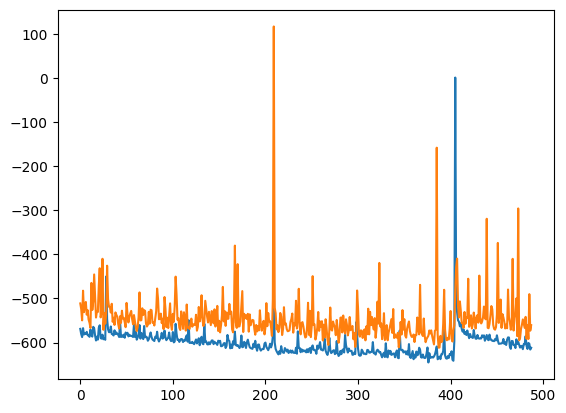

alpha 0.2 default_lr 0.0005


In [39]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [40]:
print(datetime.datetime.now())

2023-08-19 10:09:09.638002


# Iter 5

In [41]:
policy_evaluation_iter=4

In [42]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [43]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.44645  validloss 0.84287±0.00000  bestvalidloss 0.84287  last_update 0
train: iter 1  trainloss 0.39381  validloss 0.62667±0.00000  bestvalidloss 0.62667  last_update 0
train: iter 2  trainloss 0.38262  validloss 0.61542±0.00000  bestvalidloss 0.61542  last_update 0
train: iter 3  trainloss 0.38165  validloss 0.60564±0.00000  bestvalidloss 0.60564  last_update 0
train: iter 4  trainloss 0.37893  validloss 0.59598±0.00000  bestvalidloss 0.59598  last_update 0
train: iter 5  trainloss 0.37259  validloss 0.58703±0.00000  bestvalidloss 0.58703  last_update 0
train: iter 6  trainloss 0.37027  validloss 0.58240±0.00000  bestvalidloss 0.58240  last_update 0
train: iter 7  trainloss 0.36864  validloss 0.56316±0.00000  bestvalidloss 0.56316  last_update 0
train: iter 8  trainloss 0.36824  validloss 0.57232±0.00000  bestvalidloss 0.56316  last_update 1
train: iter 9  trainloss 0.36246  validloss 0.57277±0.00000  bestvalidloss 0.56316  last_update 2
train: iter 10  trai

train: iter 83  trainloss 0.34334  validloss 0.56008±0.00000  bestvalidloss 0.54744  last_update 43
train: iter 84  trainloss 0.34169  validloss 0.57840±0.00000  bestvalidloss 0.54744  last_update 44
train: iter 85  trainloss 0.34370  validloss 0.57704±0.00000  bestvalidloss 0.54744  last_update 45
train: iter 86  trainloss 0.34081  validloss 0.56732±0.00000  bestvalidloss 0.54744  last_update 46
train: iter 87  trainloss 0.34118  validloss 0.60638±0.00000  bestvalidloss 0.54744  last_update 47
train: iter 88  trainloss 0.34117  validloss 0.57041±0.00000  bestvalidloss 0.54744  last_update 48
train: iter 89  trainloss 0.34414  validloss 0.56965±0.00000  bestvalidloss 0.54744  last_update 49
train: iter 90  trainloss 0.33974  validloss 0.56452±0.00000  bestvalidloss 0.54744  last_update 50
train: iter 91  trainloss 0.34146  validloss 0.56455±0.00000  bestvalidloss 0.54744  last_update 51
train: iter 92  trainloss 0.34227  validloss 0.59478±0.00000  bestvalidloss 0.54744  last_update 52


train_loss:  -5.9564001668512825
valid_loss:  -6.010169195151329
weight_alpha 1.0 h_min_tilde -11.853981 ell_tilde -5.967153972511292 kappa_tilde 0.00020607692535509046
train_loss:  -3.03257131023407
valid_loss:  -2.6616601194381717
weight_alpha 0.2 h_min_tilde -11.853981 ell_tilde -2.95838907207489 kappa_tilde 0.00016764190135473608


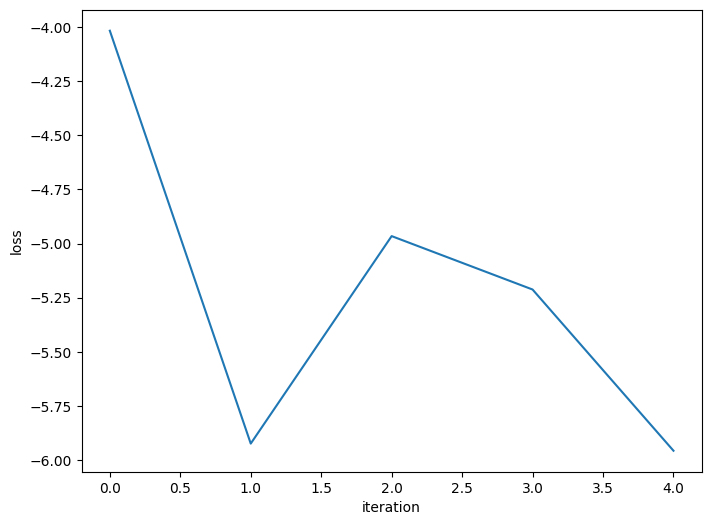

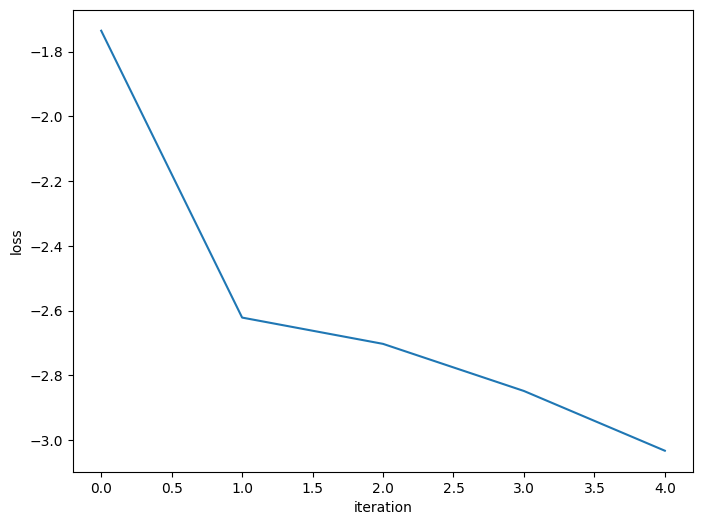

In [44]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [45]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.2
train_weighted_vae: enc_dec
train: iter 0  trainloss -607.13657  validloss -530.06238±0.00000  bestvalidloss -530.06238  last_update 0
train: iter 1  trainloss -603.00885  validloss -537.49538±0.00000  bestvalidloss -537.49538  last_update 0
train: iter 2  trainloss -607.14809  validloss -559.09520±0.00000  bestvalidloss -559.09520  last_update 0
train: iter 3  trainloss -599.62289  validloss -527.46245±0.00000  bestvalidloss -559.09520  last_update 1
train: iter 4  trainloss -606.68055  validloss -528.03973±0.00000  bestvalidloss -559.09520  last_update 2
train: iter 5  trainloss -604.46724  validloss -460.72562±0.00000  bestvalidloss -559.09520  last_update 3
train: iter 6  trainloss -588.27975  validloss -488.58450±0.00000  bestvalidloss -559.09520  last_update 4
train: iter 7  trainloss -606.96828  validloss -530.48108±0.00000  bestvalidloss -559.09520  last_update 5
train: iter 8  trainloss -612.79142  validloss -541.52110±0.00000  bestvalidloss -559.09520  last_u

train: iter 76  trainloss -626.17199  validloss -547.95026±0.00000  bestvalidloss -602.96768  last_update 27
train: iter 77  trainloss -631.05144  validloss -582.52467±0.00000  bestvalidloss -602.96768  last_update 28
train: iter 78  trainloss -626.97882  validloss -546.07540±0.00000  bestvalidloss -602.96768  last_update 29
train: iter 79  trainloss -617.19717  validloss -547.33833±0.00000  bestvalidloss -602.96768  last_update 30
train: iter 80  trainloss -620.46453  validloss -574.19429±0.00000  bestvalidloss -602.96768  last_update 31
train: iter 81  trainloss -628.25072  validloss -582.25129±0.00000  bestvalidloss -602.96768  last_update 32
train: iter 82  trainloss -609.23929  validloss -551.41435±0.00000  bestvalidloss -602.96768  last_update 33
train: iter 83  trainloss -622.08023  validloss -508.32404±0.00000  bestvalidloss -602.96768  last_update 34
train: iter 84  trainloss -616.15010  validloss -539.25684±0.00000  bestvalidloss -602.96768  last_update 35
train: iter 85  tra

train: iter 151  trainloss -628.32326  validloss -567.62336±0.00000  bestvalidloss -603.77886  last_update 7
train: iter 152  trainloss -629.93266  validloss -563.81019±0.00000  bestvalidloss -603.77886  last_update 8
train: iter 153  trainloss -627.01232  validloss -600.93542±0.00000  bestvalidloss -603.77886  last_update 9
train: iter 154  trainloss -621.64278  validloss -536.82335±0.00000  bestvalidloss -603.77886  last_update 10
train: iter 155  trainloss -584.66095  validloss -11.98118±0.00000  bestvalidloss -603.77886  last_update 11
train: iter 156  trainloss -624.22708  validloss -585.27803±0.00000  bestvalidloss -603.77886  last_update 12
train: iter 157  trainloss -627.96532  validloss -585.17790±0.00000  bestvalidloss -603.77886  last_update 13
train: iter 158  trainloss -624.98373  validloss -589.84545±0.00000  bestvalidloss -603.77886  last_update 14
train: iter 159  trainloss -631.06027  validloss -551.11278±0.00000  bestvalidloss -603.77886  last_update 15
train: iter 16

train: iter 226  trainloss -621.36418  validloss -582.56958±0.00000  bestvalidloss -617.52550  last_update 39
train: iter 227  trainloss -622.33711  validloss -550.92093±0.00000  bestvalidloss -617.52550  last_update 40
train: iter 228  trainloss -611.61716  validloss -594.89914±0.00000  bestvalidloss -617.52550  last_update 41
train: iter 229  trainloss -631.34342  validloss -582.37510±0.00000  bestvalidloss -617.52550  last_update 42
train: iter 230  trainloss -642.23644  validloss -603.10547±0.00000  bestvalidloss -617.52550  last_update 43
train: iter 231  trainloss -642.85920  validloss -574.85779±0.00000  bestvalidloss -617.52550  last_update 44
train: iter 232  trainloss -642.94413  validloss -621.84067±0.00000  bestvalidloss -621.84067  last_update 0
train: iter 233  trainloss -642.95049  validloss -582.48830±0.00000  bestvalidloss -621.84067  last_update 1
train: iter 234  trainloss -642.20900  validloss -612.08535±0.00000  bestvalidloss -621.84067  last_update 2
train: iter 2

train: iter 301  trainloss -644.47725  validloss -585.43676±0.00000  bestvalidloss -623.92147  last_update 16
train: iter 302  trainloss -650.27171  validloss -554.57794±0.00000  bestvalidloss -623.92147  last_update 17
train: iter 303  trainloss -643.49929  validloss -581.43050±0.00000  bestvalidloss -623.92147  last_update 18
train: iter 304  trainloss -643.96119  validloss -601.51101±0.00000  bestvalidloss -623.92147  last_update 19
train: iter 305  trainloss -640.14717  validloss -561.06609±0.00000  bestvalidloss -623.92147  last_update 20
train: iter 306  trainloss -642.32523  validloss -613.07912±0.00000  bestvalidloss -623.92147  last_update 21
train: iter 307  trainloss -647.41519  validloss -606.30241±0.00000  bestvalidloss -623.92147  last_update 22
train: iter 308  trainloss -618.53626  validloss -605.29655±0.00000  bestvalidloss -623.92147  last_update 23
train: iter 309  trainloss -565.75616  validloss -421.27750±0.00000  bestvalidloss -623.92147  last_update 24
train: ite

train: iter 376  trainloss -623.82321  validloss -560.43093±0.00000  bestvalidloss -638.84950  last_update 47
train: iter 377  trainloss -638.83590  validloss -577.50332±0.00000  bestvalidloss -638.84950  last_update 48
train: iter 378  trainloss -643.52870  validloss -598.68397±0.00000  bestvalidloss -638.84950  last_update 49
train: iter 379  trainloss -647.28981  validloss -591.82966±0.00000  bestvalidloss -638.84950  last_update 50
train: iter 380  trainloss -603.80028  validloss -554.40793±0.00000  bestvalidloss -638.84950  last_update 51
train: iter 381  trainloss -629.69213  validloss -571.27738±0.00000  bestvalidloss -638.84950  last_update 52
train: iter 382  trainloss -641.18230  validloss -582.95732±0.00000  bestvalidloss -638.84950  last_update 53
train: iter 383  trainloss -646.87217  validloss -592.76510±0.00000  bestvalidloss -638.84950  last_update 54
train: iter 384  trainloss -643.30233  validloss -574.83198±0.00000  bestvalidloss -638.84950  last_update 55
train: ite

train: iter 451  trainloss -637.12892  validloss -605.51841±0.00000  bestvalidloss -649.18873  last_update 34
train: iter 452  trainloss -647.55577  validloss -577.10061±0.00000  bestvalidloss -649.18873  last_update 35
train: iter 453  trainloss -657.40596  validloss -619.58810±0.00000  bestvalidloss -649.18873  last_update 36
train: iter 454  trainloss -648.03339  validloss -613.41719±0.00000  bestvalidloss -649.18873  last_update 37
train: iter 455  trainloss -648.77840  validloss -620.99462±0.00000  bestvalidloss -649.18873  last_update 38
train: iter 456  trainloss -643.93122  validloss -584.40263±0.00000  bestvalidloss -649.18873  last_update 39
train: iter 457  trainloss -657.87349  validloss -569.20623±0.00000  bestvalidloss -649.18873  last_update 40
train: iter 458  trainloss -656.63245  validloss -623.19855±0.00000  bestvalidloss -649.18873  last_update 41
train: iter 459  trainloss -650.28098  validloss -257.68057±0.00000  bestvalidloss -649.18873  last_update 42
train: ite

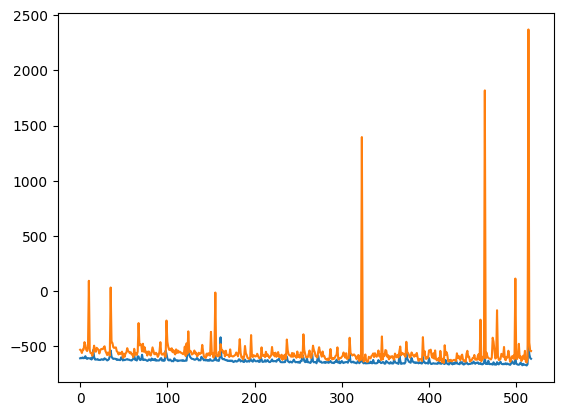

alpha 0.2 default_lr 0.0005


In [46]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [47]:
print(datetime.datetime.now())

2023-08-19 10:35:15.714003


# 評価関数計算

In [48]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71
predict diverge [ 0.55521693  3.29255458 26.73594504 33.84016464] [ 0.09051096  2.42570211 -0.69888708 18.97352019] [146.79016   23.436619 198.34738   31.218063] [73.39508  11.718309 99.17369  15.609032] sim_timestep 51

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [49]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.45940  validloss 0.59687±0.00000  bestvalidloss 0.59687  last_update 0
train: iter 1  trainloss 0.41585  validloss 0.52985±0.00000  bestvalidloss 0.52985  last_update 0
train: iter 2  trainloss 0.40997  validloss 0.51350±0.00000  bestvalidloss 0.51350  last_update 0
train: iter 3  trainloss 0.39819  validloss 0.51143±0.00000  bestvalidloss 0.51143  last_update 0
train: iter 4  trainloss 0.40101  validloss 0.52126±0.00000  bestvalidloss 0.51143  last_update 1
train: iter 5  trainloss 0.39235  validloss 0.51202±0.00000  bestvalidloss 0.51143  last_update 2
train: iter 6  trainloss 0.39309  validloss 0.51997±0.00000  bestvalidloss 0.51143  last_update 3
train: iter 7  trainloss 0.39150  validloss 0.50178±0.00000  bestvalidloss 0.50178  last_update 0
train: iter 8  trainloss 0.38689  validloss 0.51897±0.00000  bestvalidloss 0.50178  last_update 1
train: iter 9  trainloss 0.38718  validloss 0.51995±0.00000  bestvalidloss 0.50178  last_update 2
train: iter 10  trai

train: iter 83  trainloss 0.36124  validloss 0.52892±0.00000  bestvalidloss 0.50178  last_update 76
train: iter 84  trainloss 0.35903  validloss 0.52887±0.00000  bestvalidloss 0.50178  last_update 77
train: iter 85  trainloss 0.35730  validloss 0.52960±0.00000  bestvalidloss 0.50178  last_update 78
train: iter 86  trainloss 0.35385  validloss 0.52848±0.00000  bestvalidloss 0.50178  last_update 79
train: iter 87  trainloss 0.36003  validloss 0.54051±0.00000  bestvalidloss 0.50178  last_update 80
train: iter 88  trainloss 0.35390  validloss 0.52894±0.00000  bestvalidloss 0.50178  last_update 81
train: iter 89  trainloss 0.35852  validloss 0.54888±0.00000  bestvalidloss 0.50178  last_update 82
train: iter 90  trainloss 0.36203  validloss 0.52615±0.00000  bestvalidloss 0.50178  last_update 83
train: iter 91  trainloss 0.35861  validloss 0.54777±0.00000  bestvalidloss 0.50178  last_update 84
train: iter 92  trainloss 0.35527  validloss 0.53953±0.00000  bestvalidloss 0.50178  last_update 85


([0.45939706088975074,
  0.41585362181067465,
  0.4099716114811599,
  0.398189022578299,
  0.40101422676816584,
  0.39234645795077083,
  0.39308809507638215,
  0.39149594604969024,
  0.38688670760020616,
  0.38717505186796186,
  0.3826291123405099,
  0.38316438496112826,
  0.383098872192204,
  0.38044327273964884,
  0.3829238394275308,
  0.3797833416610956,
  0.3748547175899148,
  0.37762366579845547,
  0.37444605957716703,
  0.3781130339950323,
  0.38184802010655405,
  0.3763891952112317,
  0.3800548706203699,
  0.38367192801088096,
  0.37477787435054777,
  0.37645374704152346,
  0.3783190449699759,
  0.3765527168288827,
  0.3727485742419958,
  0.37378283180296423,
  0.374639412201941,
  0.37522894106805327,
  0.38243559347465633,
  0.3701603518798947,
  0.3707058632746339,
  0.3697169847786427,
  0.37483034152537587,
  0.37033412139862776,
  0.36936943493783475,
  0.36790155805647373,
  0.36841696025803683,
  0.37069772742688656,
  0.3685484115965664,
  0.3717045681551099,
  0.370812

In [50]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -6.4207440635204325
valid_loss:  -6.130400558543205
weight_alpha 1.0 h_min_tilde -11.840187 ell_tilde -6.362675362524986 kappa_tilde 0.00021363792295262855
train_loss:  -3.069216095638275
valid_loss:  -2.6706913900375366
weight_alpha 0.2 h_min_tilde -11.840187 ell_tilde -2.989511154518127 kappa_tilde 0.00016806674344186097


In [51]:
train_curve, valid_curve = iwvi.train_initial_belief(num_iter=100000, lr=1e-3, early_stop_step=default_early)


train: iter 0  trainloss 111.33105  validloss 129.88456±0.00000  bestvalidloss 129.88456  last_update 0
train: iter 1  trainloss 89.30491  validloss 101.06034±0.00000  bestvalidloss 101.06034  last_update 0
train: iter 2  trainloss 71.57146  validloss 80.59324±0.00000  bestvalidloss 80.59324  last_update 0
train: iter 3  trainloss 57.84334  validloss 65.05788±0.00000  bestvalidloss 65.05788  last_update 0
train: iter 4  trainloss 47.84682  validloss 53.58140±0.00000  bestvalidloss 53.58140  last_update 0
train: iter 5  trainloss 39.38864  validloss 43.99105±0.00000  bestvalidloss 43.99105  last_update 0
train: iter 6  trainloss 32.48568  validloss 35.32390±0.00000  bestvalidloss 35.32390  last_update 0
train: iter 7  trainloss 26.94721  validloss 29.40213±0.00000  bestvalidloss 29.40213  last_update 0
train: iter 8  trainloss 23.20326  validloss 24.16083±0.00000  bestvalidloss 24.16083  last_update 0
train: iter 9  trainloss 19.62586  validloss 20.54322±0.00000  bestvalidloss 20.54322 

train: iter 87  trainloss -0.05669  validloss -0.55691±0.00000  bestvalidloss -0.59644  last_update 1
train: iter 88  trainloss -0.02799  validloss -0.50052±0.00000  bestvalidloss -0.59644  last_update 2
train: iter 89  trainloss -0.06713  validloss -0.53030±0.00000  bestvalidloss -0.59644  last_update 3
train: iter 90  trainloss -0.08393  validloss -0.54123±0.00000  bestvalidloss -0.59644  last_update 4
train: iter 91  trainloss -0.07645  validloss -0.54125±0.00000  bestvalidloss -0.59644  last_update 5
train: iter 92  trainloss -0.08400  validloss -0.54045±0.00000  bestvalidloss -0.59644  last_update 6
train: iter 93  trainloss -0.11370  validloss -0.53873±0.00000  bestvalidloss -0.59644  last_update 7
train: iter 94  trainloss -0.10515  validloss -0.61215±0.00000  bestvalidloss -0.61215  last_update 0
train: iter 95  trainloss -0.13737  validloss -0.58869±0.00000  bestvalidloss -0.61215  last_update 1
train: iter 96  trainloss -0.13310  validloss -0.56155±0.00000  bestvalidloss -0.6

train: iter 177  trainloss -0.26293  validloss -0.57895±0.00000  bestvalidloss -0.66482  last_update 66
train: iter 178  trainloss -0.24473  validloss -0.58278±0.00000  bestvalidloss -0.66482  last_update 67
train: iter 179  trainloss -0.22629  validloss -0.62081±0.00000  bestvalidloss -0.66482  last_update 68
train: iter 180  trainloss -0.21618  validloss -0.53657±0.00000  bestvalidloss -0.66482  last_update 69
train: iter 181  trainloss -0.25713  validloss -0.55731±0.00000  bestvalidloss -0.66482  last_update 70
train: iter 182  trainloss -0.25327  validloss -0.61450±0.00000  bestvalidloss -0.66482  last_update 71
train: iter 183  trainloss -0.23490  validloss -0.61459±0.00000  bestvalidloss -0.66482  last_update 72
train: iter 184  trainloss -0.24433  validloss -0.58779±0.00000  bestvalidloss -0.66482  last_update 73
train: iter 185  trainloss -0.23481  validloss -0.55527±0.00000  bestvalidloss -0.66482  last_update 74
train: iter 186  trainloss -0.23544  validloss -0.53218±0.00000 

In [52]:
print(iwvi.initial_belief)


Parameter containing:
tensor([ 0.9776, -1.3253, -3.1398, -3.4271], requires_grad=True)


In [53]:
train_curve, valid_curve = iwvi.train_penalty(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early)

train: iter 0  trainloss 18.13287  validloss 48.38017±0.00000  bestvalidloss 48.38017  last_update 0
train: iter 1  trainloss 16.72565  validloss 40.63222±0.00000  bestvalidloss 40.63222  last_update 0
train: iter 2  trainloss 15.79502  validloss 45.38318±0.00000  bestvalidloss 40.63222  last_update 1
train: iter 3  trainloss 15.40196  validloss 44.94848±0.00000  bestvalidloss 40.63222  last_update 2
train: iter 4  trainloss 15.41942  validloss 41.05661±0.00000  bestvalidloss 40.63222  last_update 3
train: iter 5  trainloss 15.24844  validloss 43.08304±0.00000  bestvalidloss 40.63222  last_update 4
train: iter 6  trainloss 15.20353  validloss 45.02724±0.00000  bestvalidloss 40.63222  last_update 5
train: iter 7  trainloss 14.99955  validloss 39.53232±0.00000  bestvalidloss 39.53232  last_update 0
train: iter 8  trainloss 15.03226  validloss 43.10098±0.00000  bestvalidloss 39.53232  last_update 1
train: iter 9  trainloss 15.07497  validloss 44.80047±0.00000  bestvalidloss 39.53232  last

train: iter 81  trainloss 14.36929  validloss 42.31280±0.00000  bestvalidloss 36.13387  last_update 11
train: iter 82  trainloss 14.29483  validloss 38.43664±0.00000  bestvalidloss 36.13387  last_update 12
train: iter 83  trainloss 14.25020  validloss 43.97823±0.00000  bestvalidloss 36.13387  last_update 13
train: iter 84  trainloss 14.15513  validloss 38.87374±0.00000  bestvalidloss 36.13387  last_update 14
train: iter 85  trainloss 14.34227  validloss 40.97779±0.00000  bestvalidloss 36.13387  last_update 15
train: iter 86  trainloss 14.21962  validloss 42.33408±0.00000  bestvalidloss 36.13387  last_update 16
train: iter 87  trainloss 14.16214  validloss 34.46466±0.00000  bestvalidloss 34.46466  last_update 0
train: iter 88  trainloss 14.29285  validloss 38.69681±0.00000  bestvalidloss 34.46466  last_update 1
train: iter 89  trainloss 14.44075  validloss 38.06652±0.00000  bestvalidloss 34.46466  last_update 2
train: iter 90  trainloss 14.41361  validloss 36.92767±0.00000  bestvalidlos

train: iter 162  trainloss 14.15112  validloss 39.10964±0.00000  bestvalidloss 34.46466  last_update 75
train: iter 163  trainloss 13.94836  validloss 39.36304±0.00000  bestvalidloss 34.46466  last_update 76
train: iter 164  trainloss 13.93659  validloss 39.51303±0.00000  bestvalidloss 34.46466  last_update 77
train: iter 165  trainloss 13.93242  validloss 41.00712±0.00000  bestvalidloss 34.46466  last_update 78
train: iter 166  trainloss 14.00574  validloss 42.02914±0.00000  bestvalidloss 34.46466  last_update 79
train: iter 167  trainloss 13.85408  validloss 44.33483±0.00000  bestvalidloss 34.46466  last_update 80
train: iter 168  trainloss 13.99065  validloss 42.86669±0.00000  bestvalidloss 34.46466  last_update 81
train: iter 169  trainloss 14.04878  validloss 44.76536±0.00000  bestvalidloss 34.46466  last_update 82
train: iter 170  trainloss 13.96192  validloss 43.33874±0.00000  bestvalidloss 34.46466  last_update 83
train: iter 171  trainloss 13.95637  validloss 41.42774±0.00000 

In [54]:
iwvi.save(ckpt_key="policy_optimization_iter1")

iwvi save ckpt1, ckpt2 ckpt_iwvi_basepartcartpole_policy_optimization_iter1 ckpt_iwvi_cartpole_policy_optimization_iter1
base save ckpt ckpt_basevi_cartpole_policy_optimization_iter1
base load self.initial_belief.data.sum() tensor(-6.9146)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(2.8360)


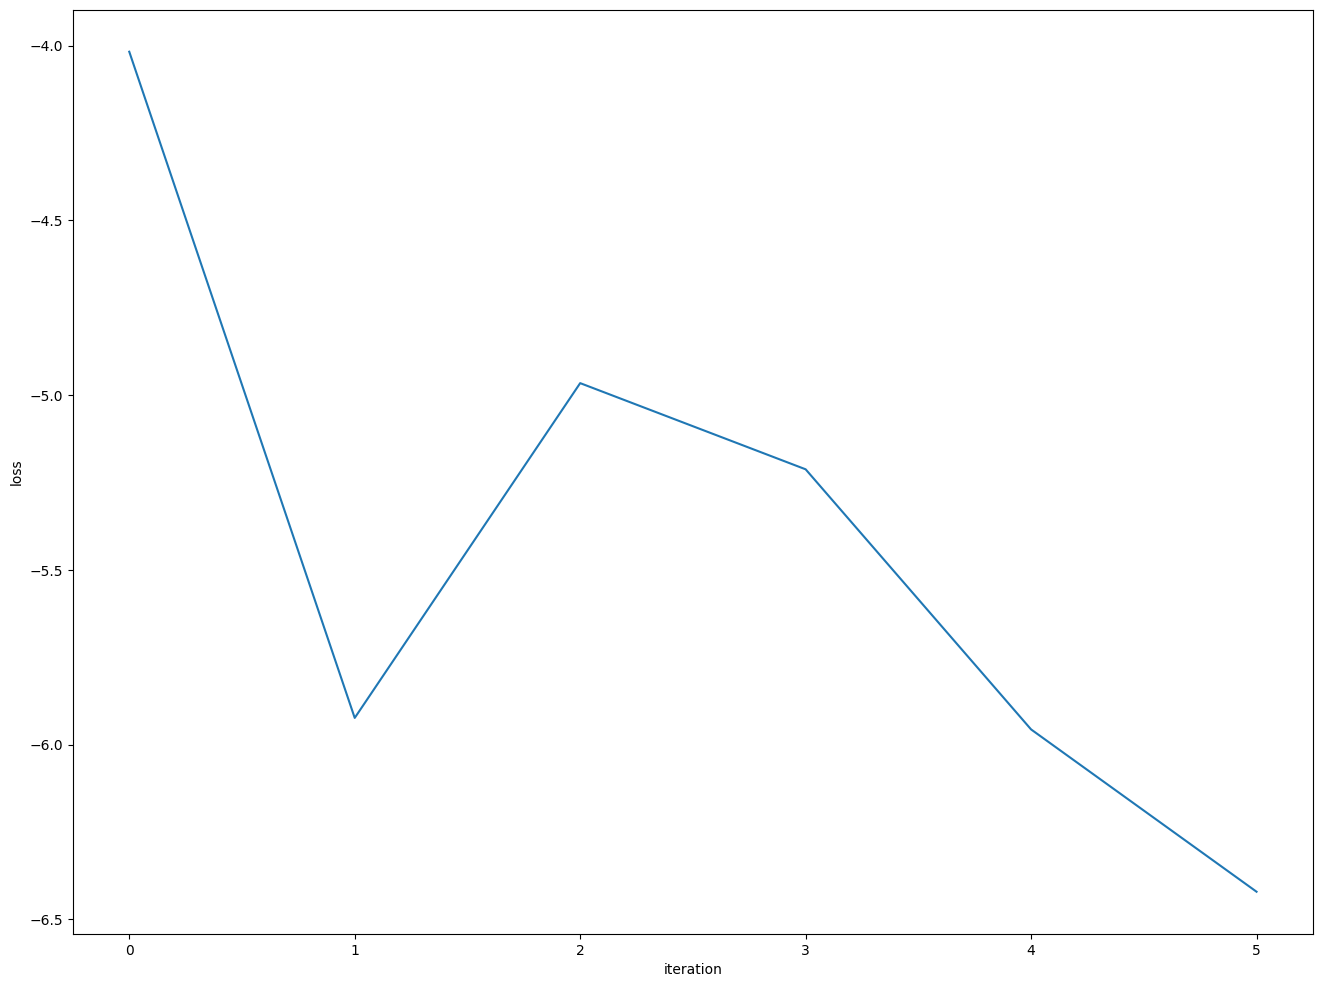

In [55]:
loss_array = np.array(loss_list)
plt.figure(figsize=(16,12))
plt.plot(loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve.png")
plt.savefig(figfilenamehead+"learning_curve.eps")
# plt.savefig(figfilenamehead+"policy_evaluartion_learning_curve.pdf")

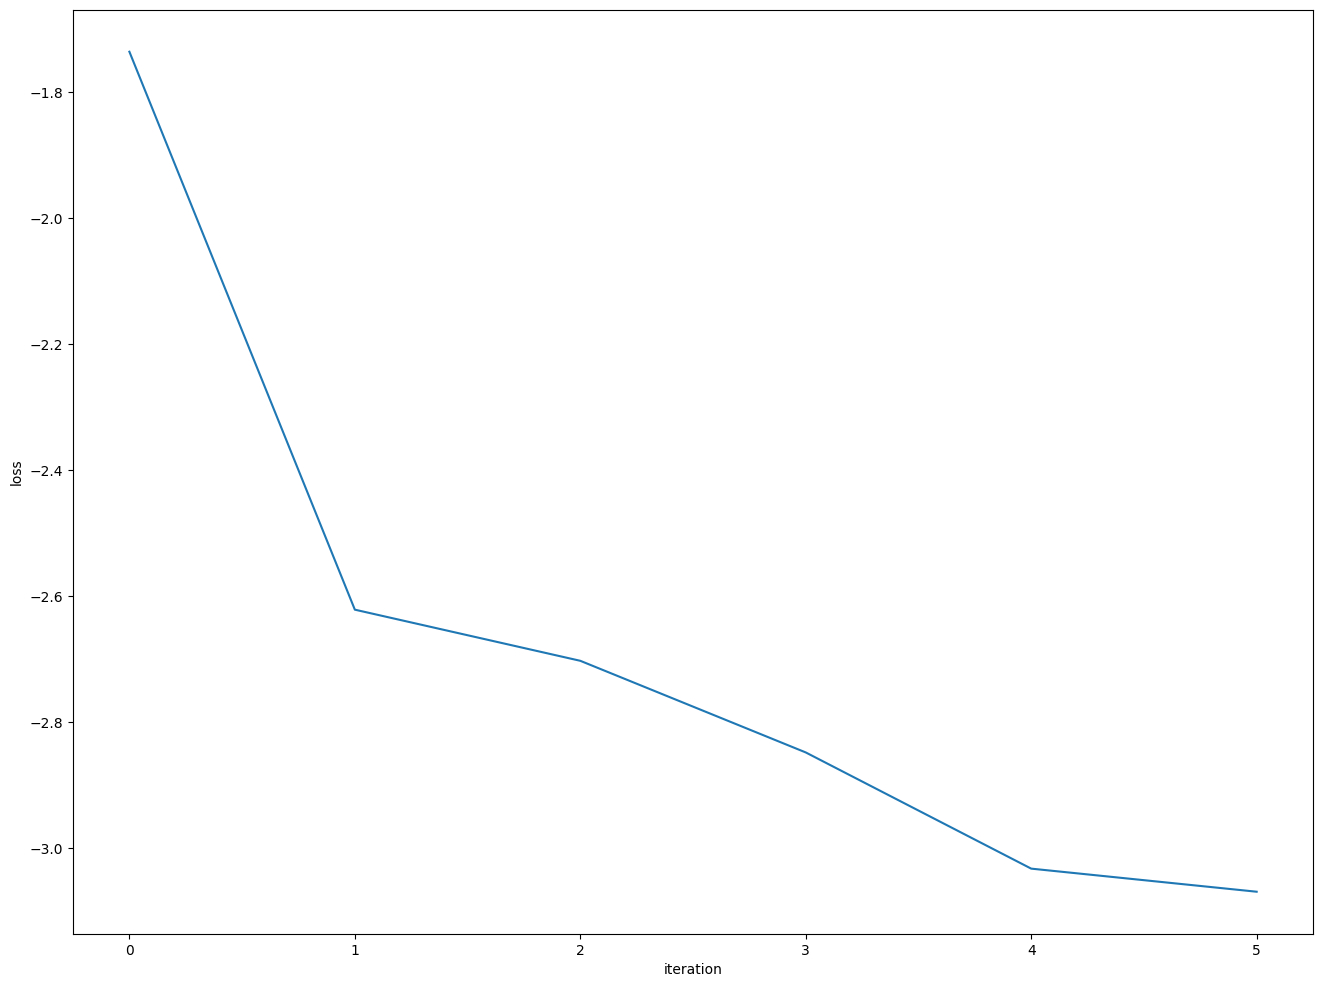

In [56]:
normalized_loss_array = np.array(normalized_loss_list)
plt.figure(figsize=(16,12))
plt.plot(normalized_loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".png")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".eps")